# 09 Parallelization Recap

In [1]:
from IPython.display import Image
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%alias clean rm -f *.c *.exe *.py *.pyc *.s .*f95 *.o *.fo *log *.h *.cc *.mod *.ppm *.png temp_field_*

In [3]:
%clean

In [4]:
!cat $HOME/Dropbox/Slackware/gcc_vars.sh

export PATH=/usr/local/gcc-7.3.0/bin:$PATH
export COMPILER_PATH=/usr/local/gcc-7.3.0/bin

export LIBRARY_PATH=/usr/local/gcc-7.3.0/lib:/usr/local/gcc-7.3.0/lib64:$LIBRARY_PATH
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib:/usr/local/gcc-7.3.0/lib64:$LD_LIBRARY_PATH

export CPATH=/usr/local/gcc-7.3.0/include
export C_INCLUDE_PATH=/usr/local/gcc-7.3.0/include
export CPLUS_INCLUDE_PATH=/usr/local/gcc-7.3.0/include
export OBJC_INCLUDE_PATH=/usr/local/gcc-7.3.0/include

export CC=/usr/local/gcc-7.3.0/bin/gcc
export CXX=/usr/local/gcc-7.3.0/bin/g++
export FC=/usr/local/gcc-7.3.0/bin/gfortran
export CPP=/usr/local/gcc-7.3.0/bin/cpp

export MANPATH=/usr/local/gcc-7.3.0/share/man:${MANPATH}


## Goals

1. To have a brief review of what we have discussed
2. To have a llok at few additional topics

as always, with an hands on approach

## Outline

[0. Recap on CPU architecture, performance and parallel programming](#zero)  
[1. Vectorization](#one)  
[2. OpenMP](#two)  
[3. MPI](#three)  

<a id="zero"></a>

# 0 - Recap on CPU architecture, performance and parallel programming

### 0.1 Architecture and performance constrains

Progress and performance of computer architecture have been dominated for decades by a logscale growth of the number of transistors on a single socket:

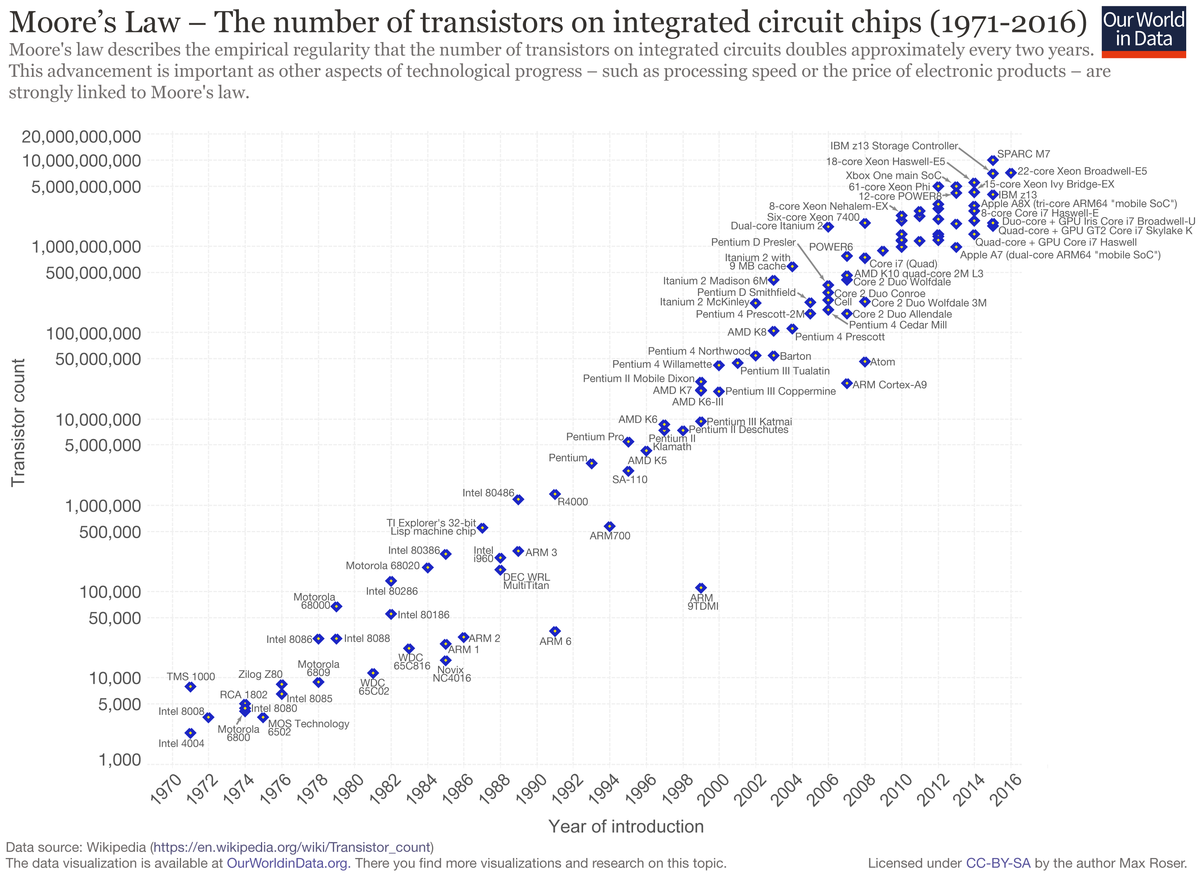

In [5]:
Image("pictures/1200px-Moore's_Law_Transistor_Count_1971-2016.png")

The fundamental constrains on CPU performance are power and heat:

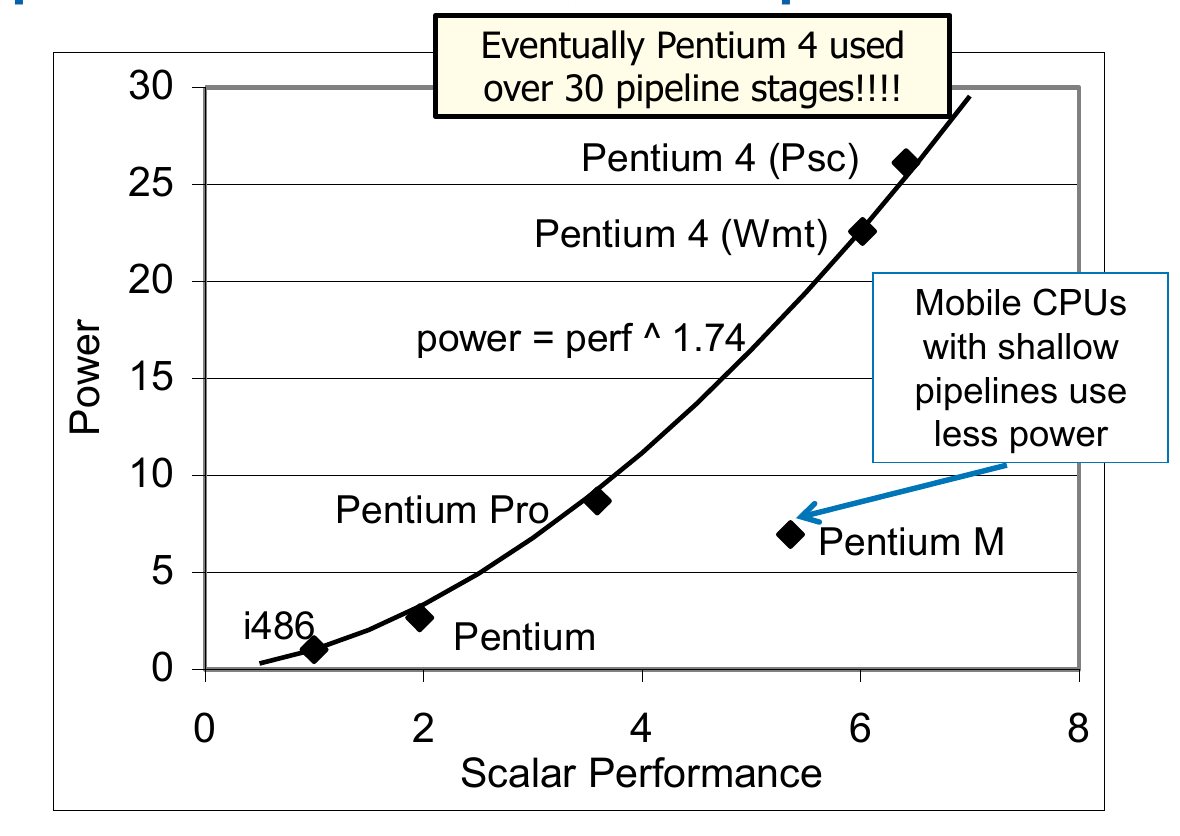

In [6]:
Image("pictures/power2.png")

which needs to be dissipated.

That spawned the **multi core** and **many core** paradigms which incorporated parallelism into desktop computers:

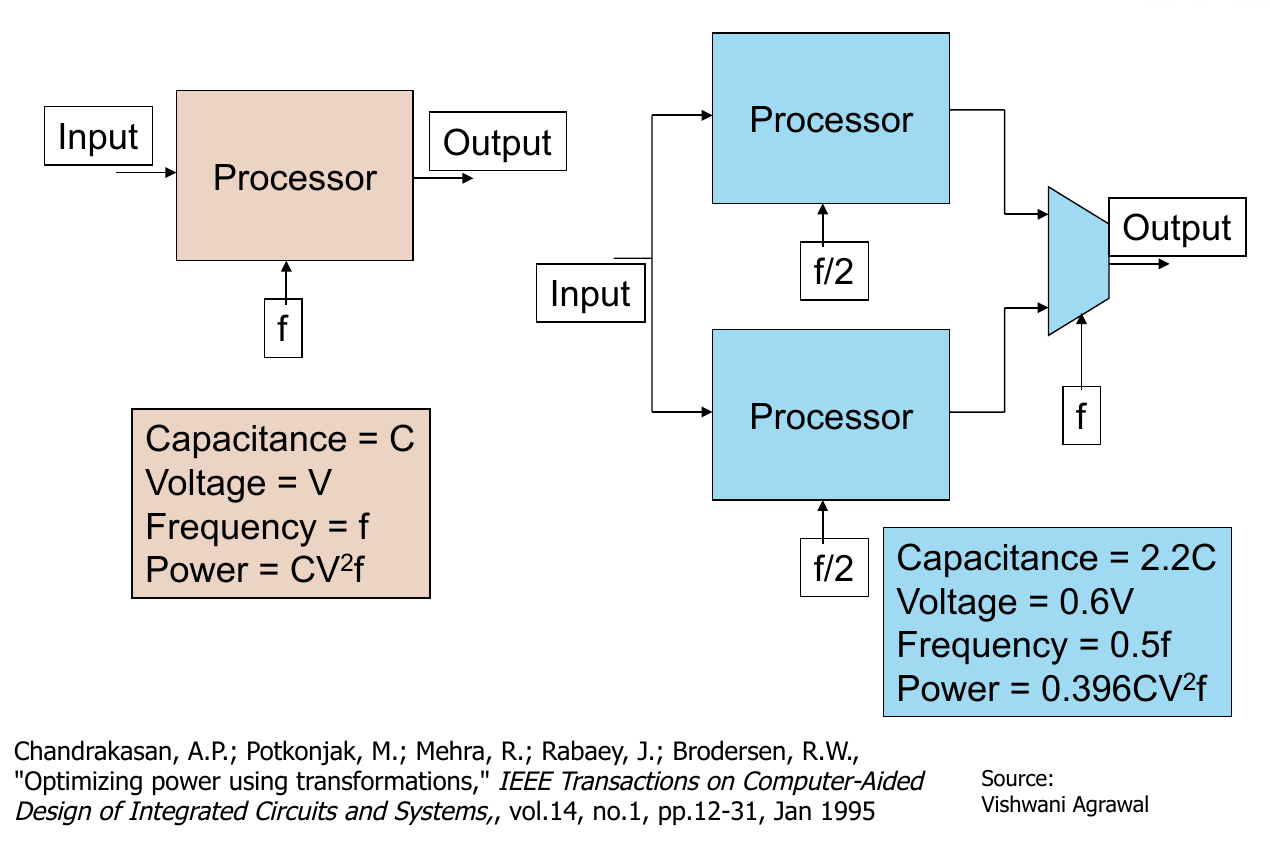

In [7]:
Image("pictures/more_cores.png")

*hence to get full advantage of current CPU you need to know a little bit of parallelism*

CPUs are based on a relatively simple paradigm, 

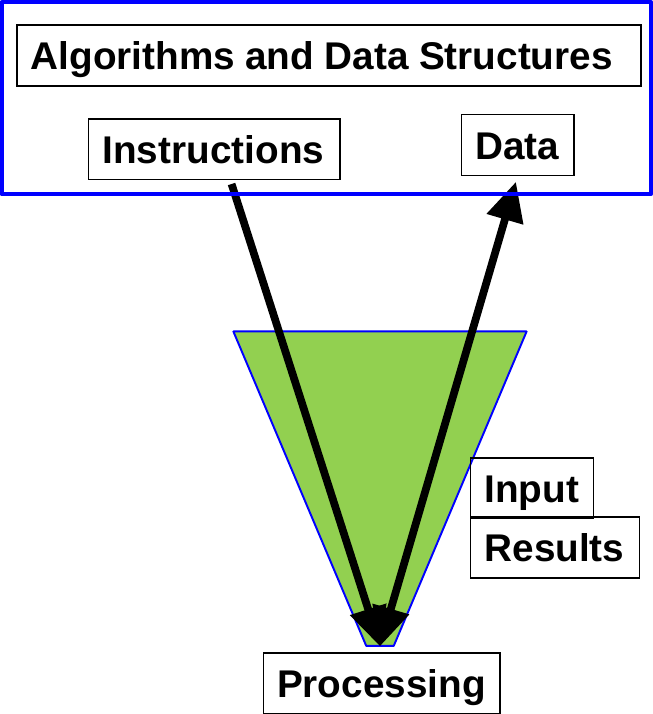

In [8]:
Image("pictures/von_neumann.png")

but a single core is a complex object:

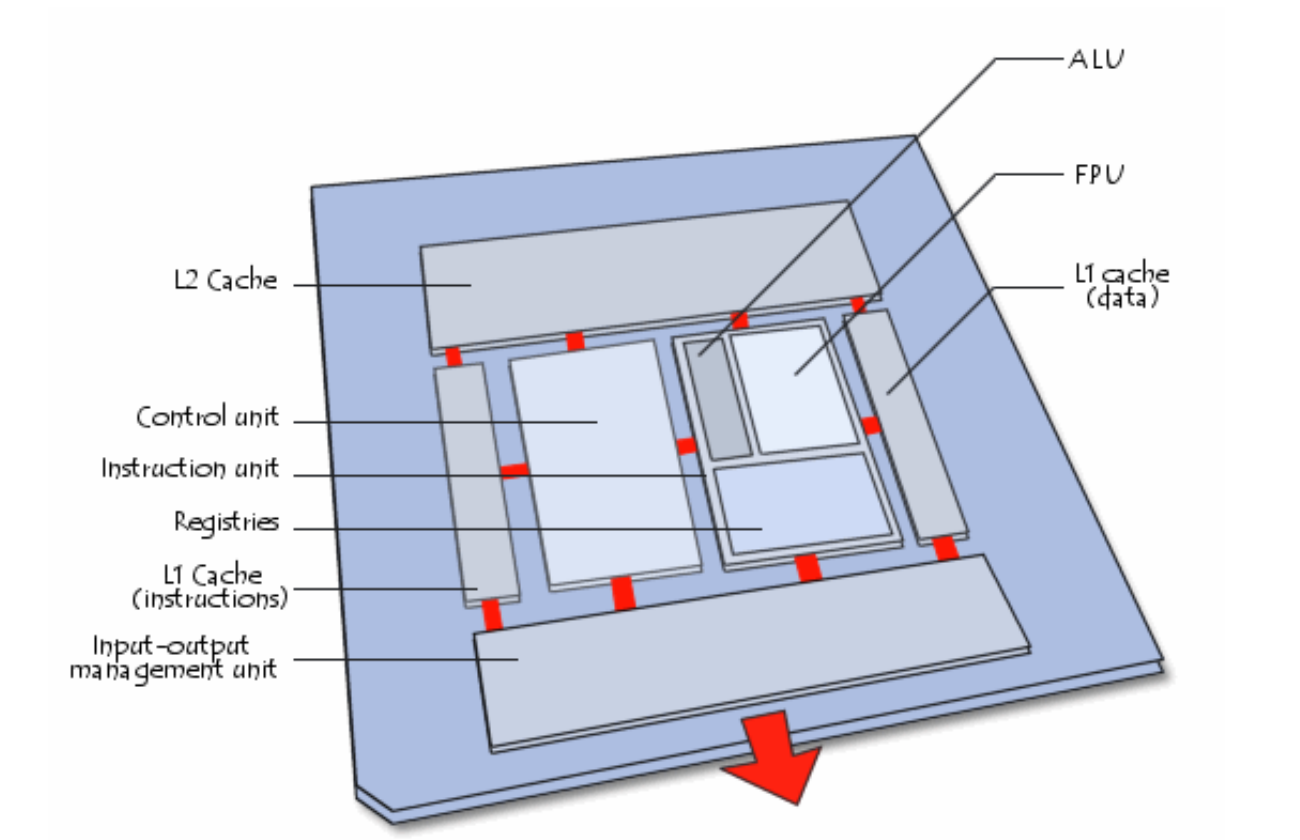

In [9]:
Image("pictures/onecore.png")

Instructions and data must be continuously fed to the control and arithmetic units, so that the speed of the memory interface poses a limitation on compute performance (von Neumann bottleneck).

The architecture is inherently sequential, processing a single instruction with (possibly) a single operand or a group of operands from memory. 

And we have several layers of optimization:

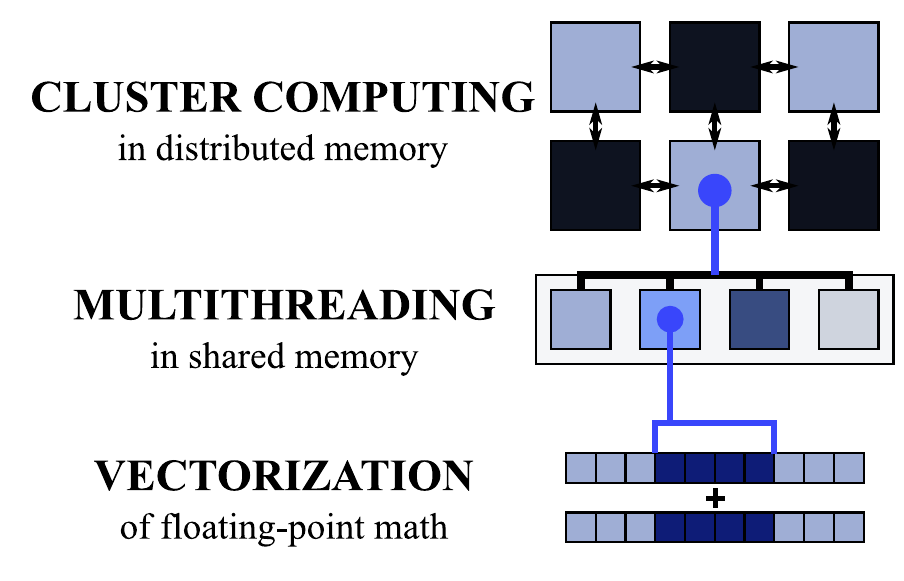

In [10]:
Image("pictures/perfo_dim.png")

- Sharing of compute load with a communication protocol:  
    - (Gigabit) Ethernet
    - High-speed fabric (e. g. [Infiniband](#https://en.wikipedia.org/wiki/InfiniBand) or [Intel Omnipath](#https://en.wikipedia.org/wiki/Omni-Path)).  
    - Network topology may be rather complex.  
    - Each node may be itself a NUMA archicture with separated multicore sockets.

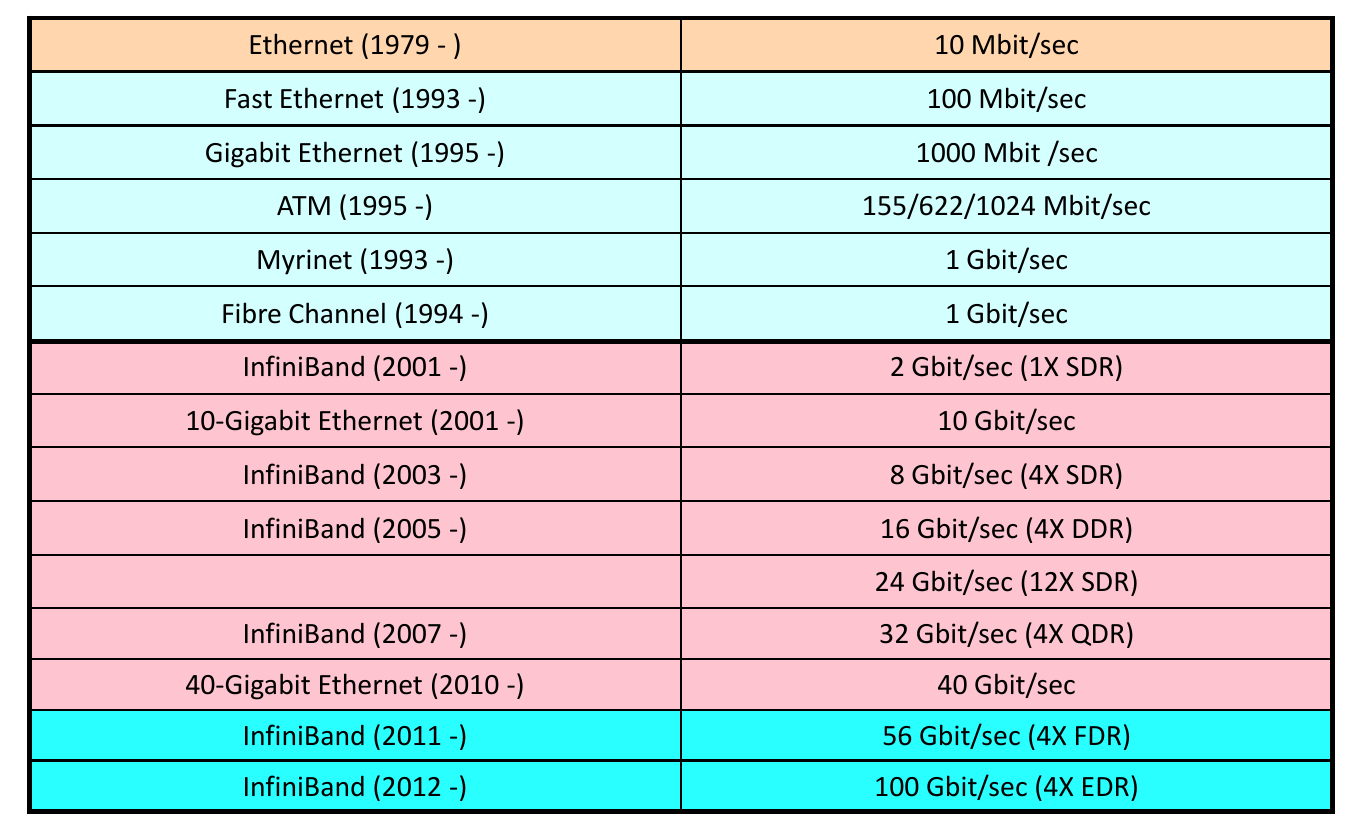

In [11]:
Image("pictures/networks.png")

### Memory layout

Computer memory is organized in a hierarchy of decreasing price and speed and increasing capacity. Caches are small and fast and main memory is big and slow. 

So chaches need to map memory several memory locations (as a juggler does with balls).

Cache divided into cache lines: when memory is read into cache, a whole cache line is always read at the same time.  
Good if we have data locality: nearby memory accesses will be fast.  
Typical cache line size: 64-128 bytes

- L1 (approx. 10-100 kB) 1-5 cycles
- L2 (256 kB- ) 10-20 cycles
- L3 (> 2 MB), slower

Programs often re-use nearby memory locations:
- Temporal locality: probably we will need again soon data from a location
- Spatial locality: nearby addresses likely to be needed soon

Example: reuse nearby elements in dense matrix multiplication (one of the past examples)

**How cheap are FLOPs?**

Rough estimate for one socket of the [Mulliken node](#http://avogadro.sns.it/ganglia/)

Intel(R) Xeon(R) Gold 6132 CPU @ 2.60GHz with avx512:

- 14 cores
- 8 vector lanes per core
- 14 cores * 2.6 GHz * 2 FMA * 32 IPC * 8 vector lanes ~ 1165 GFLOP/s
- 1165 GFLOP/s * 8 bytes ~ 9.3 TFLOP/s

Maximum RAM bandwidth~ 0.12 TB/s. Hence 9.3/0.12 ~ 77.5 FLOPS per memory access.  
Therefore, on this platform to have a compute bound application you must achieve approximately 78 FLOPS x access.

**Strip mining and Cache Blocking**

Suppose we have the following code:

    for (int i = 0; i < m; i++) 
        for (int j = 0; j < n; j++)
            compute(a[i], b[j]); 

at each step we use a `b[j]` then throw it away and load the next. For `n` large with respect to cache lines size, performance is determined by memory bandwidth.

now suppose we partially unroll manually the inner loop:

    for (int i = 0; i < m; i++)
        for (int jj = 0; jj < n; jj += TILE)
            for (int j = jj; j < jj + TILE; j++)
                compute(a[i], b[j]); 
                
where `TILE` is the cache line size. This is called *strip mining* (too much jargon) and, among other things may help the compiler to vectorize code. But we have still a memory bound snippet.

what happens if the loop are permuted?

    for (int jj = 0; jj < n; jj += TILE)
        for (int i = 0; i < m; i++)
            for (int j = jj; j < jj + TILE; j++)
                compute(a[i], b[j]); 

we load `TILE` elements from `b[j]` and then use it for all computations, thereby increasing *temporal locality*. This is called also *cache blocking* with block of size `TILE`.

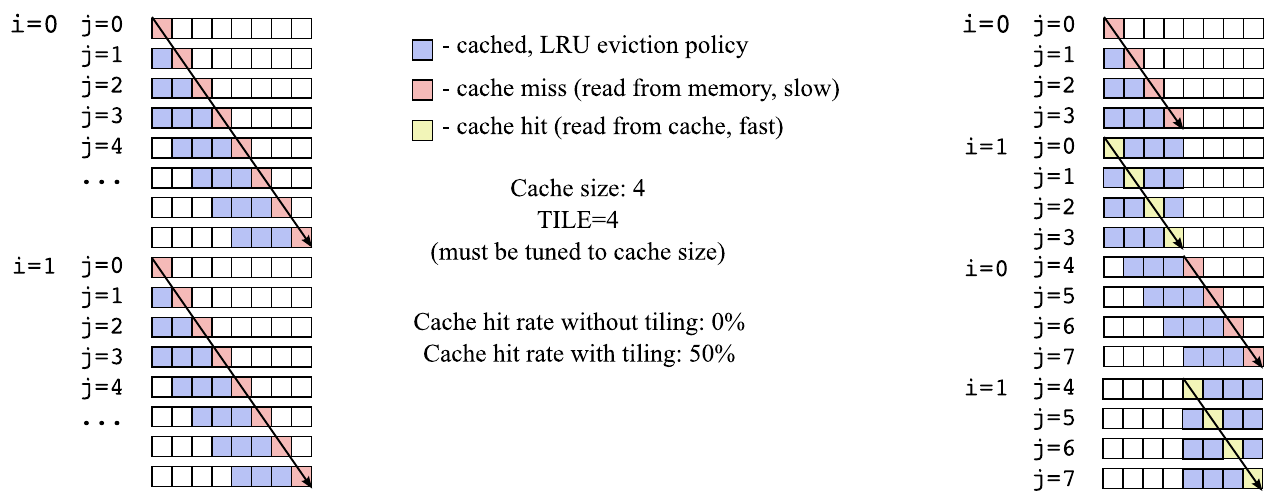

In [12]:
Image("pictures/cache_block.png")

**Compiler optimization**

Once we have set up a decent piece of code we can ask the copiler to help a little bit:

In [13]:
!gcc -O1 -Q --help=optimizers | grep enabled | grep inline

  -finline                    		[enabled]
  -finline-atomics            		[enabled]
  -finline-functions-called-once 	[enabled]


broadly speaking, compiler optimization can:
    
- reduce the number of operations
- reduce their mathematical complexity
- increase the data locality of operations
- use architecture specific optimizationand instructions sets

#### Arrays of Structures vs Structures of arrays

Suppose you to write a code simulating the the behaviour of many particle system, under some physical model, that is integrating its equation of motion. You need data structures to hold basic information such positions, velocities, etc.

One way could be:

    typedef struct Particle
    {
        float position[3];
        float velocitiy[3];
        float force[3];
        float mass;
        char tag[20];
    } particle

then would be easy to form arrays of particles `particle System[nparticles]` and operate on them. Adding new features to particles would involve changing the structure and some functions for specific tasks, with (possibly) little modifications.  
Using C++, classes and OOP would make it even more portable.

However what happens when run into a loop like that:  

    for(int i = 0; i < nparticles; i++)
        for(int j = 0; j < 3; j++)
            System[i].position[j] += timestep * System[i].velocity[j]; // Euler int.
            
locality is not guaranteed and is very difficult for the compiler to optimise aggresively (and prevent vectorization).        

Alternatively:    
    
    #define maxp 1e6;
    
    typedef ParticleSystem
    {
        float Positions = malloc(maxp * 3 * sizeof(float);
        ...
    } System;

    system mysystem System, *sysptr;
    float *X = sysprt->X; // deference then access member: (*ptr_to_s).member
    float *V = systptr->V;
    
    ...
    
    for(int i = 0; i < nparticles; i++)
        for(int j = 0; j < 3; j++)
            X[i][j] += timestep * V[i][j]; 

this is a common wisdom for performance oriented development and is called to create *structures of arrays* instead of *arrays fo structures* ([*SoA* vs *Aos*](#https://en.wikipedia.org/wiki/AOS_and_SOA)).

### 0.2 Parallel programming.

**[Flynn Taxonomy](#https://en.wikipedia.org/wiki/Flynn%27s_taxonomy)**

Parallel Computers are (or used to be) classified according to categories first proposed by M. Flynn in the 60s (see https://ieeexplore.ieee.org/document/5009071?reload=true). The classification is done permutating on the presence of single or multiple *instructions streams* and *data streams*:

- SISD: **S**ingle **I**nstruction, **S**ingle **D**ata.  
- SIMD: **S**ingle **I**nstruction, **M**ultiple **D**ata.  
- MISD: **M**ultiple **I**nstruction, **S**ingle **D**ata.  
- MIMD: **M**ultiple **I**nstruction, **M**ultiple **D**ata.  

**Parallel programming jargon**

**Band**  
amount of data moved over time unit. Measured in $bytes\  s^{-1}$ (hard disks) and $bit\  s^{-1}$ (sockets and nodes)

**Latency**
minimum time needed to assign a requested resource

**Performance**
number of 64 bit floating point operations per second

**Concurrency**
A condition of a system in which multiple tasks are logically active at one time.

**Parallelism**
A condition of a system in which multiple tasks are actually active at one time."

**Parallel application**   
An application composed of tasks that actually execute concurrently in order to (1) consider larger problems in fixed time or (2) complete in less time for a fixed size problem.

**Load imbalance**  
The slowest process determines when everyone is done. Time waiting for other processes to
finish  is time wasted.

**Communication overhead**  
A cost only incurred by the parallel program. Grows with the number of processes for collective communication.

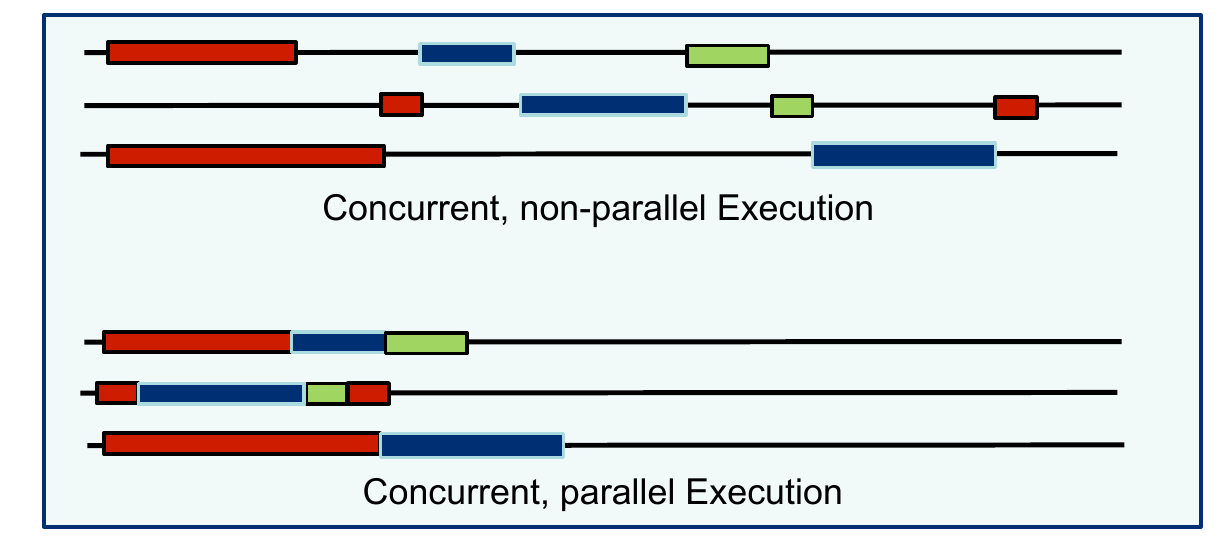

In [14]:
Image("pictures/parallel.png")

**Amdhal Law**
$$T_{par} = \frac{T_{ser}}{p} = T_{ser}*f_s + f_p*\frac{T_{ser}}{p} = (\alpha+\frac{1-\alpha}{p})*T_{ser}$$  
$$ S = \frac{T_{ser}}{T_{par}} = \frac{1}{\alpha+\frac{1-\alpha}{p}}$$

**Weak Scaling**
$$ S(P) \to S(P,N) $$
$$ S(P,N) = \frac{T_{ser}}{T_{par}} = \frac{1}{\alpha+\frac{1-\alpha}{p}}$$
$$ N \to \infty  \Rightarrow \alpha \to 0 $$
$$ S(P,N)_{\alpha \to 0} = P $$

<a id="one"></a>

# 1 - Vectorization

- Perform one operation on multiple elements of a vector  
- Chunk-wise processing instead of element wise  
- Can lower computational cost  
- A form of **Single Instruction Multiple Data** (SIMD) parallelism

basically, in addition to adding cores, I also add more FPU units per core

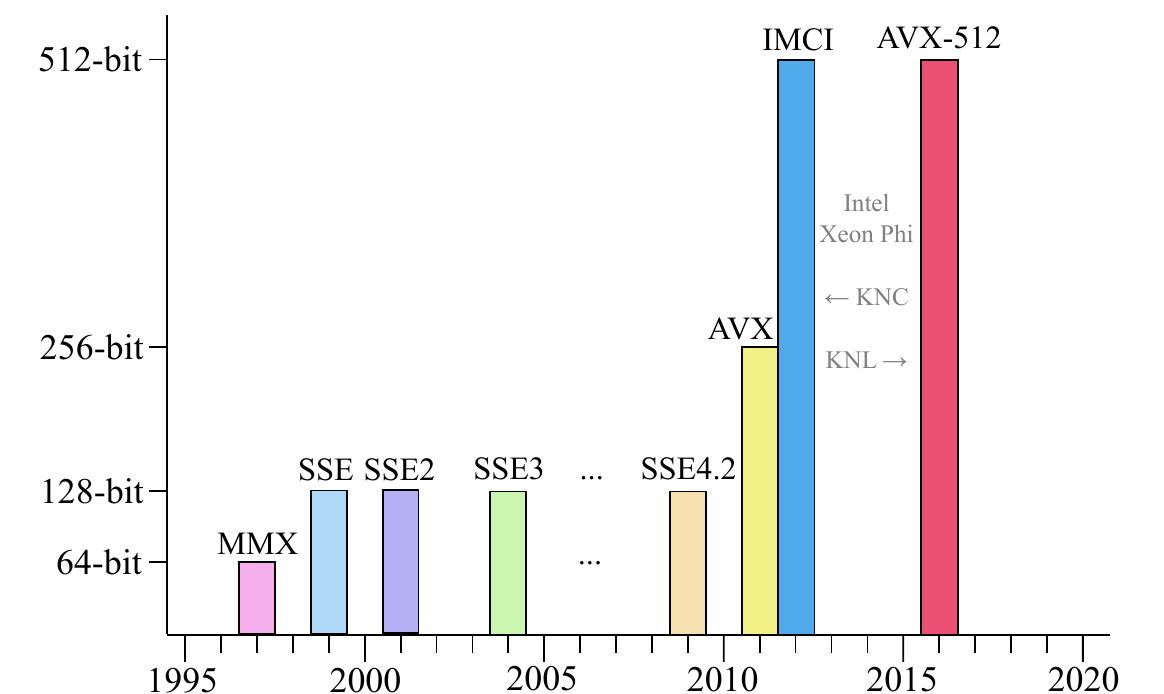

In [15]:
Image("pictures/inst_set.png")

- 1997 with MMX instruction set: 80-bit registers.  
- 2000+ SSE instruction sets (several versions of them, from SSE1 to SEE4.2): 128-bit registers.  
- 2011, Intel Sandy Bridge, AVX instruction set: 256-bit registers.  
- 2016, Intel AVX-512: 512-bit registers.  

See also [here](#https://software.intel.com/en-us/articles/intel-xeon-processor-scalable-family-technical-overview).

Vectorization requires to sue specific registers (*XMM*, *YMM*) and assembly or compiler intrisics and switches.

On Intel, SSE/AVX intrinsic functions use the following naming convention:

    _<vector_size/instruction set>_<intrin_op>_<prec_suffix>

- <vector_size> is mm for 128 bit vectors (SSE), mm256 for 256 bit vectors (AVX and AVX2), and mm512 for AVX512.
- <intrin_op> Declares the operation of the intrinsic function. I.e. add, sub, mul ...
- <suffix> Indicates the datatype. ps is for float, pd for double, and ep<int_type> is for integer datatypes: epi32 for signed 32 bit integer, epu16 for unsigned 16 bit integer ...

For instance a vector intrisic multiplication for double vectors with AVX:

    _mm256_mul_pd(&a , &a)
    
Single precision square root:

    _mm256_sqrt_pf(&a).
    
There are notable features not available with intrisics, including:

1. Random numbers
2. Integer division

Available by including `immintrin.h`.

for a complete list, see [#here](https://software.intel.com/sites/landingpage/IntrinsicsGuide/)

GCC supports multiple architectures and different header files are provided to use intrisics:
    
- arm_neon.h - ARM Neon types & intrinsics
- altivec.h - Freescale Altivec types & intrinsics
- mmintrin.h - X86 MMX
- xmmintrin.h - X86 SSE1
- emmintrin.h - X86 SSE2

Example of data load with intrisics:

In [16]:
%%writefile access_128.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
#include <x86intrin.h> 
// g. mancini july 18
int main()
{
    float x[4] = {10., 20., 30., 40.};
    __m128 One =  {10., 20., 30., 40.};
    __m128 Two =  _mm_load_ps(x);
    __m128 Three =  _mm_set_ps(10., 20., 30., 40.);
    for(int v=0; v < 4; v++)
        printf("%d %f %f %f %f\n",v,x[v],One[v],Two[v],Three[v]);
    printf("--------------\n\n");
    
    float y[8] = {10., 20., 30., 40., 50. ,60., 70., 80.};
    __m128 Four = _mm_load_ps(y);
    for(int i=0; i < 2; i++)
        for(int v=0; v < 4; v++)
            printf("%d %d %f %f \n",v,i*4+v,y[i*4+v],Four[i*4+v]);

    return 0;
}

Writing access_128.c


In [17]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -msse4.2 -o access.exe access_128.c
./access.exe
rm -f access.exe

0 10.000000 10.000000 10.000000 40.000000
1 20.000000 20.000000 20.000000 30.000000
2 30.000000 30.000000 30.000000 20.000000
3 40.000000 40.000000 40.000000 10.000000
--------------

0 0 10.000000 10.000000 
1 1 20.000000 20.000000 
2 2 30.000000 30.000000 
3 3 40.000000 40.000000 
0 4 50.000000 10.000000 
1 5 60.000000 20.000000 
2 6 70.000000 30.000000 
3 7 80.000000 40.000000 


**OpenMP SIMD extensions**

From version 4.0 onwards it can handled by *OpenMP pragmas*:

    #pragma omp simd <something>
    !$OMP simd <something>

Intrisics vs OpenMP pragmas:

In [18]:
%%writefile intr_vs_pragma.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
#include <x86intrin.h> 
//g. mancini july 18
int main()
{
    const int steps = 1e7;
    double *arr = calloc(sizeof(double), steps);
    
    printf("non vectorized\n");
    double t0 = omp_get_wtime();  
    for(int i = 0; i < steps; i++)
        arr[i] = (double ) i;
    double time = 1000.*(omp_get_wtime() - t0);
    printf("time=%f\n", time);
    
    printf("intrisics\n");
    int dim = 2; //SSE
    t0  = omp_get_wtime();  
    for(int i = 0; i < steps/dim; i += dim)
    {
        __m128d tmp = {(double ) i+1,(double ) i};
        _mm_storeu_pd(&arr[i], tmp);
    }
    if( steps % dim != 0) 
        for(int i = (steps/dim)*dim; i < steps; i++)
            arr[i] = (double ) i;
    time = 1000.*(omp_get_wtime() - t0);
    printf("time=%f\n", time);

    printf("OpenMP\n");
    t0  = omp_get_wtime();  
    #pragma omp simd
    for(int i=0; i < steps; i++)
        arr[i] = (double ) i;;
    time = 1000.*(omp_get_wtime() - t0);
    printf("time=%f\n", time);
    
    return 0;
}

Writing intr_vs_pragma.c


In [19]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -msse4.2 -fopenmp -o intr_vs_pragma.exe intr_vs_pragma.c
echo $OMP_NUM_THREADS
./intr_vs_pragma.exe
rm -f intr_vs_pragma.exe


non vectorized
time=21.300893
intrisics
time=4.626742
OpenMP
time=9.601765


### Exercise 1.0

1. Write a program for calculating $\pi$ using intrisics. (Last time we see this example, I promise). Compare with non vectorized.

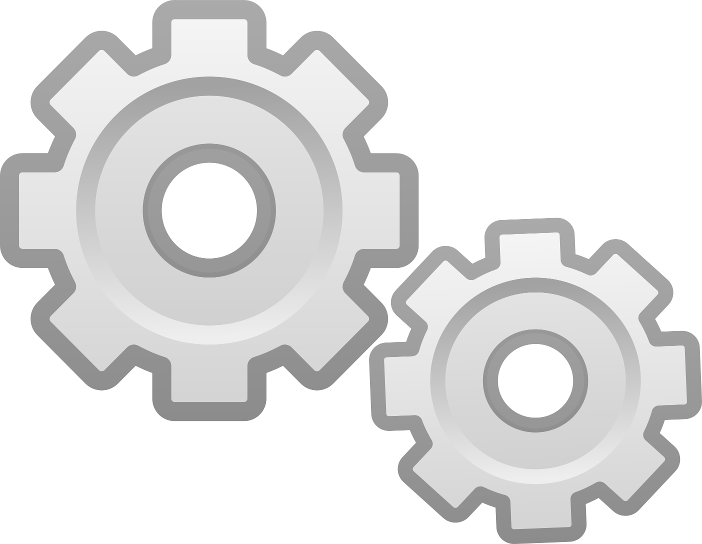

In [20]:
Image("pictures/gears.png")

** Solution 1.0 **

In [21]:
%%writefile integral_intrisic.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
#include <x86intrin.h> 
//g. mancini july 18
int main()
{
    const long steps = 1E8;
    const double start = 0.;
    const double end   = 1.;
    
    double I  = 0.;
    const double dx = (end-start) / ((double ) steps);
    double t0 = omp_get_wtime();   
    for(int i=0; i < steps; i++)
    {
        double mid_x = start + dx * ((double ) i + 0.5);
        double mid_y = 1.0/(1. + mid_x*mid_x);
        I += mid_y;
    }
    I = 4. * I * dx;
    double time = 1000.* (omp_get_wtime() - t0);
    printf("PI=%f, evaluated in %f ms\n",I, time);
    I = 0.;
    
    t0 = omp_get_wtime();
    printf("Evalute PI in vectorized loop\n");
    __m128d num = _mm_set_pd(4.,4.);
    __m128d IV  = _mm_set_pd(0.,0.);
    for(int i = 0; i < steps; i = i+2)
    {
        __m128d x = _mm_set_pd(i*dx, (i+1)*dx);
        IV =_mm_add_pd(IV,_mm_div_pd(num,1+_mm_mul_pd(x,x)));
    }
    for(int i = 0; i < 2; i++)
        I += IV[i];
    I = I * dx;
    time = 1000.* (omp_get_wtime() - t0);
    printf("PI=%f, evaluated in %f ms\n",I, time);
    
    return 0; 
}

Writing integral_intrisic.c


In [22]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -msse4.2 -fopenmp -o integral_intrisic.exe integral_intrisic.c
./integral_intrisic.exe

PI=3.141593, evaluated in 690.445218 ms
Evalute PI in vectorized loop
PI=3.141593, evaluated in 345.213376 ms


<a id="two"></a>

# 2 - OpenMP

**Shared memory computer** : any computer composed of multiple processing elements that share an address space.

Two Classes:
- Symmetric multiprocessor (SMP): a shared address space with “equal-time” access for each processor, and the OS treats every processor the same way. (Real SMP have not existed for many years, see slides of class#1)

- Non Uniform address space multiprocessor (NUMA;you have one of these): different memory regions have different access costs ... think of memory segmented into “Near” and “Far” memory.

**Process**
- An instance of a program execution.
- The execution context of a running program ... i.e. the resources associated with a program’s execution.

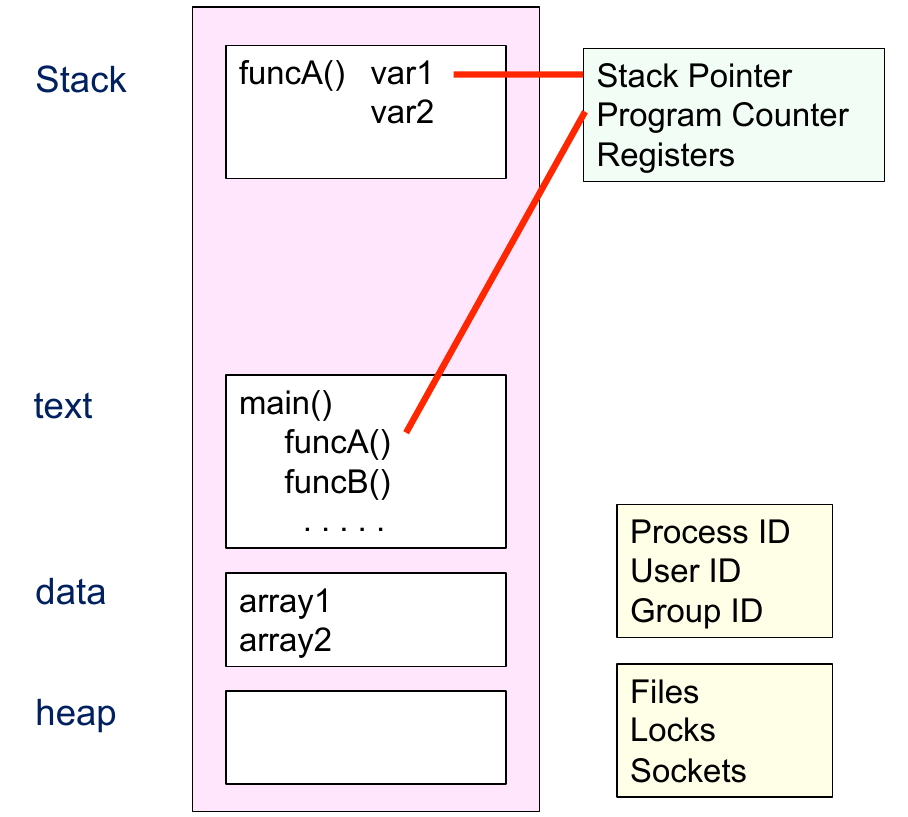

In [23]:
Image("pictures/process.png")

**Thread**:

- Threads are "light weight processes”
- Threads share process state among multiple threads ... this greatly reduces the cost of switching context.

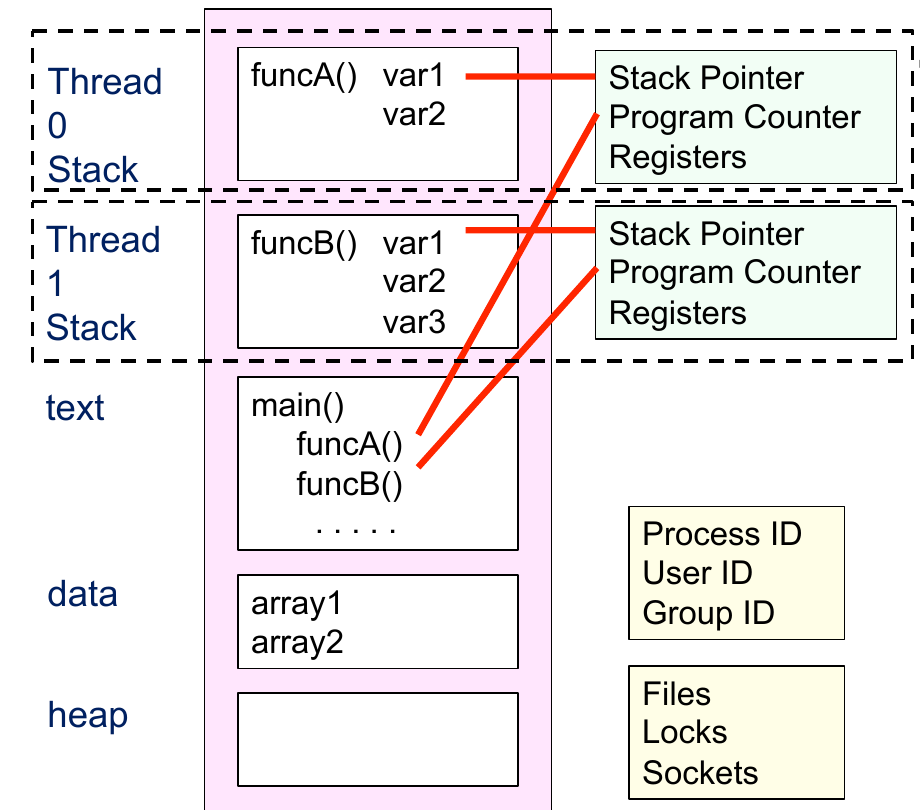

In [24]:
Image("pictures/Thread.png")

** A shared memory program**

- One process and lots of threads.
- Threads interact through reads/writes to a shared address space.
- An OS scheduler decides when to run which threads ... interleaved for fairness.
- Synchronization to assure every legal order results in correct results.

How do threads interact?

- Threads communicate by sharing variables.
- Unintended sharing of data causes **race conditions**:
    - race condition: when the program’s outcome changes as the threads are scheduled differently.
- To control race conditions:
    - Use synchronization to protect data conflicts.
- Synchronization is expensive so:
    - Change how data is accessed to minimize the need for synchronization.

**OpenMP** i. e. *Open Multi Processing* an Application Program Interface (API) for developing multithreaded applications.

**OpenMP core syntax**

Most of the constructs in OpenMP are compiler directives.
    #pragma omp construct [clause [clause]...]
        
Example
    #pragma omp parallel num_threads(4)
    
Function prototypes and types in the file:
    #include <omp.h>

Most OpenMP constructs apply to a *structured block*:
- Structured block: a block of one or more statements with one point of entry at the top and one point of exit at the bottom.

*Parallel regions* are created with OpenMP whenever you invoke `#pragma omp parallel`. From that point until the end of the region (structured block closed or `!$OMP end parallel`) a *team of threads* is spawned and the code is executed indepently by each thread.

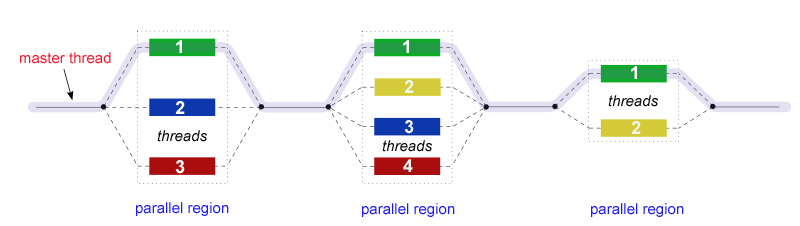

In [25]:
Image("pictures/fork_join.jpeg")

- Unintended sharing of data causes **race conditions** in which the program's results depend on thread scheduling.
- To control race conditions: use **synchronization** to protect data conflicts.
- Synchronization is expensive so: change how data is accessed to minimize the need for synchronization.
- Synchronization may use **barriers** (all threads in a team) or **mutual exclusions (mutexes)** (a pair of threads)

**Work sharing constructs**

- Loop construct
- Single construct
- Master construct
- Sections construct
- Task construct

**Sections construct**

    #pragma omp parallel 
    {
        #pragma omp sections
        {
            #pragma omp section
            {
                // structured block 1
            }
            #pragma omp section
            {
                // structured block 2
            }
            #pragma omp section
            {
                // structured block 3
            }           
            ...
        }
    }

`sections` starts the construct. It contains several `section` constructs which marks a different block, containing a represents a task. (Beware of section and section**s**).  

`sections` distributes the blocks/tasks between existing threads. The requirement is that each block must be independent of the other blocks. Then each thread executes one block at a time. Each block is executed only once by one thread.

**Environment Variables**

- OMP_NUM_THREADS number of threads   
- OMP_SCHEDULE (when using schedule(runtime) in loop worksharing constructs)  
- OMP_THREADLIMIT maximum number of threads  
- OMP_STACKSIZE maximum *thread* stack size  
- GOMP_CPU_AFFINITY: how threads are bound to CPUs; e. g. GOMP_CPU_AFFINITY="0 2 1 3"  
- OMP_PROC_BIND: allows (or not) to move threads; overrides affinity  
- OMP_DISPLAY_ENV

see also the [gcc documentation](#https://gcc.gnu.org/onlinedocs/libgomp/Environment-Variables.html)

#### Example: $\pi$ integration with reduction

(I lied)

In [26]:
%%writefile integral_omp_red.cc
#include <iostream>
#include <omp.h>
//g. mancini july 18
int main(int argc, char **argv)
{
    
    const int num_steps = 1e8;
    const double start  = 0.;
    const double end    = 1.;
    
    double I  = 0.;
    const double dx = (end-start) / ((double ) num_steps);
    double t0 = omp_get_wtime();   
    
    #pragma omp parallel for reduction(+:I) schedule(static,1)
    for(int i=0; i < num_steps; i++)
    {
        double mid_x = start + dx * ((double ) i + 0.5);
        double mid_y = 4.0/(1. + mid_x*mid_x) ;
        I += mid_y;
    }
    I = I * dx;
    double t1 = omp_get_wtime();
    
    std::cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms using " << std::endl;
    std::cout  << "Integral value = " << I << std::endl;
}

Writing integral_omp_red.cc


In [27]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
g++ -Wall -O2 -fopenmp -march=native -mtune=native -o integral.exe integral_omp_red.cc -lm
OMP_NUM_THREADS=1 ./integral.exe

Loop completed in 690.51 ms using 
Integral value = 3.14159


In [28]:
%%capture pibench
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH 
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe
OMP_NUM_THREADS=8 ./integral.exe

In [29]:
pat = re.compile(r'(Loop\scompleted\sin\s)(.+)\sms')
result = pat.findall(pibench.stdout) 
result = np.array(list(map(lambda x:float(x[-1]),result)))

In [30]:
plt.plot((1,2,4,8),result,marker='s',color='k',ls='-')
plt.ylabel('Wall time')
plt.xlabel('number of threads')

Text(0.5,0,'number of threads')

### Exercise 2.0

Mandelbrot set

The Mandelbrot set is an iterative map in the complex plane:  
$$ z_{n+1}^2 = z_{n}^2 + c $$
where $c$ is a constant and $z_0=0$.  
Points that do not diverge after a finite number of iterations are part of the set. 

1. Write a serial code for the Mandelbrot set.
2. Write an OpenMP version.

In [31]:
%%writefile template.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
//g. mancini july 18
void main(int argc, char *argv[])
{

    //settings
    const int maxiter = 500;
    double horiz   = 2.0;
    const int width   = 1024;
    const int height  = 1024;
    const double xmin = -2.;
    const double xmax =  1.;
    const double ymin = -1.2;
    const double ymax =  1.2;
    const char* filename = "out.ppm";
        
    //variables
    int k;
    horiz = horiz*horiz;
    double x0, y0, xres, yres;
    xres = (xmax - xmin)/((double) width);
    yres = (ymax - ymin)/((double) height);
    double re, im, re2, im2;
    
    // open output PPM file, https://en.wikipedia.org/wiki/Netpbm_format#PPM_example
    unsigned char colour[3];
    FILE * fp = fopen(filename,"w");
    fprintf(fp,"P3\n%d %d %d\n",width, height, 255);    
    //compute map for every pixel
    //write black &  white out file
}

Writing template.c


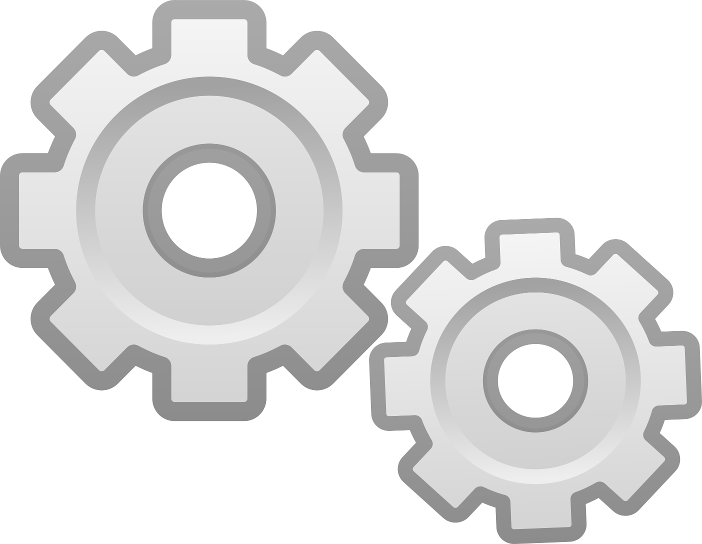

In [32]:
Image("pictures/gears.png")

** Solution 2.0 **

In [33]:
%%writefile mandelbrot_serial.c
// g mancini apr 18
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
#include <omp.h>
//g. mancini july 18
inline int mandel(double x0, double y0, double thres, int maxiter)
    {
        double re  = 0.0;
        double im  = 0.0;
        double re2 = 0.0;
        double im2 = 0.0;
        int k;
        for (k = 0; k < maxiter && (re2 + im2 < thres); k++) 
        {
            im = 2. * re * im + y0;
            re = re2 - im2 + x0;
            re2 = re * re;
            im2 = im * im;
        }    
        return k;
    }

void write_output(char* filename, int* image, int width, int height, int maxiter)
{
    
    // open output PPM file, https://en.wikipedia.org/wiki/Netpbm_format#PPM_example
    FILE * fp = fopen(filename,"w");
    fprintf(fp,"P3\n%d %d %d\n",width, height, 255);    

    for (int i=0; i< height; i++)
    {
        for (int j=0; j < width; j++)
        {           
            if(image[i + j*height] == maxiter)
                fprintf(fp,"%d %d %d ",0,0,0);
            else
                fprintf(fp,"%d %d %d ",255,255,255);
        }
        fprintf(fp,"\n");
    }
    fclose(fp);     
}
    
int main(int argc, char *argv[])
{
    //settings
    const int maxiter =  500;
    double thres      =    3.0;
    const int width   = 800;
    const int height  = 800;
    const double xmin =   -2.;
    const double xmax =    1.;
    const double ymin =   -1.2;
    const double ymax =    1.2;
    char* filename = "out.ppm";
    //variables
    thres = thres*thres;
    double x0, y0, xres, yres;
    xres = (xmax - xmin)/((double) width);
    yres = (ymax - ymin)/((double) height);
    int *image = malloc(sizeof(int) * height * width); 
    double t0 = omp_get_wtime();
    //calculate
    y0 = ymin;
    for (int i=0; i< height; i++)
    {
        x0 = xmin;
        for (int j=0; j < width; j++)
        {
            image[i + j*height] = mandel(x0,y0,thres,maxiter);
            x0 = x0 + xres;
        }   
        y0 = y0 + yres;
    }// close on i    
    printf("Spent %f seconds\n",omp_get_wtime()-t0);
    write_output( filename, image, width, height, maxiter);
    free(image);
}

Writing mandelbrot_serial.c


In [34]:
%%bash
rm -f out.*
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -fopenmp -o mandelbrot.exe mandelbrot_serial.c
./mandelbrot.exe
#https://www.imagemagick.org/script/index.php
convert out.ppm out.png

Spent 0.290289 seconds


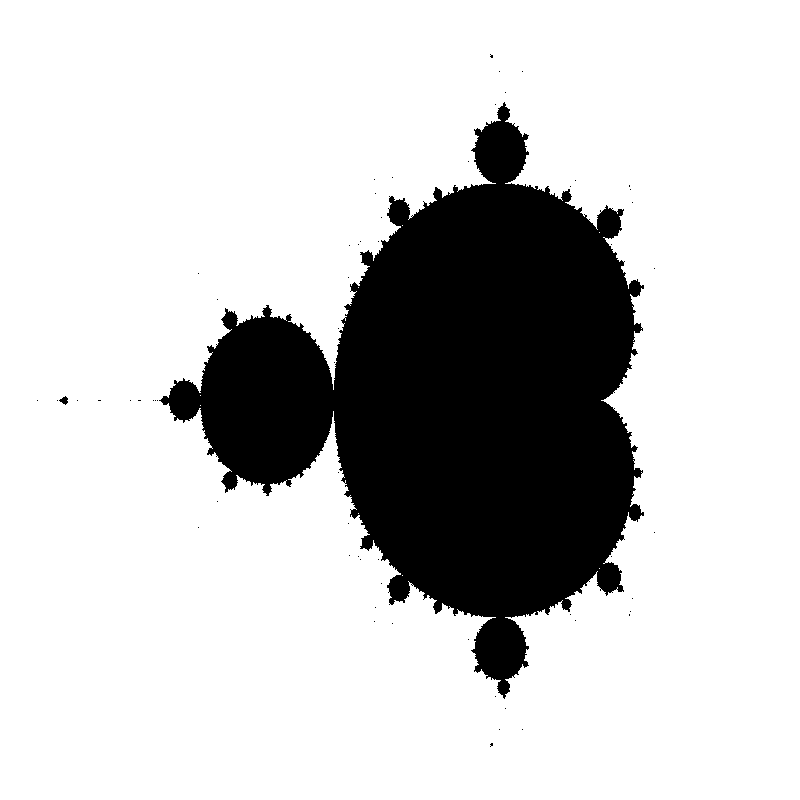

In [35]:
Image("out.png")

In [36]:
%%timeit
%%bash
./mandelbrot.exe

Spent 0.290186 seconds
Spent 0.290366 seconds
Spent 0.291028 seconds
Spent 0.290333 seconds
1 loop, best of 3: 468 ms per loop


In [37]:
!rm -f mandelbrot.exe

#### OpenMP version

In [38]:
%%writefile mandelbrot_omp.c
// g mancini apr 18
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <omp.h>
//g. mancini july 18
inline int mandel(double x0, double y0, double tr, int maxiter)
    {
        double re  = 0.0;
        double im  = 0.0;
        double re2 = 0.0;
        double im2 = 0.0;
        int k;
        
        for (k = 1; k < maxiter && (re2 + im2 < tr); k++) 
        {
            im = 2. * re * im + y0;
            re = re2 - im2 + x0;
            re2 = re * re;
            im2 = im * im;
        }    
        return k;
    }

void write_output(char* filename, int* image, int width, int height, int maxiter)
{
    // open output PPM file, https://en.wikipedia.org/wiki/Netpbm_format#PPM_example
    FILE * fp = fopen(filename,"w");
    fprintf(fp,"P3\n%d %d %d\n",width, height, 255);    

    for (int i = 0; i < height; i++)
    {
        for (int j=0; j < width; j++)
        {           
            if(image[i + j*height] >= maxiter)
                fprintf(fp,"%d %d %d ",0,0,0);
            else
                fprintf(fp,"%d %d %d ",255,255,255);
        }
        fprintf(fp,"\n");
    }
    fclose(fp);     
}
    
int main(int argc, char *argv[])
{
    //settings
    const int maxiter   =  500;
    const int width     = 2048;
    const int height    = 2048;
    const double xmin   =   -2.;
    const double xmax   =    1.;
    const double ymin   =   -1.2;
    const double ymax   =    1.2;
    char* filename = "out.ppm";
    double horiz  = 3.0;
    
    //variables
    horiz = horiz*horiz;
    double xres, yres;
    xres = (xmax - xmin)/((double) width);
    yres = (ymax - ymin)/((double) height);
    
    //allocate image
    int *image = malloc(sizeof(int) * height * width); 
    
    // run
#ifdef _OPENMP
    double t0 = omp_get_wtime();
    int block = 8;
    #pragma omp parallel for schedule(dynamic) //collapse(2) 
    for(int jj = 0; jj < width; jj+=block)
        for (int i = 0; i < height; i++)
        {    
            for (int j = jj; j < jj + block; j++)
            {
                double x0 = xmin + j*xres;
                double y0 = ymin + i*yres;
                image[i + j*height] = mandel(x0,y0,horiz,maxiter);                
            }   
        }// close on i   
    
    double t1 = omp_get_wtime();
    printf("spent %f ms in parallel loop\n",(t1-t0)*1000.0);
#else
    double y0 = ymin;
    for (int i = 0; i< height; i++)
    {
        double x0 = xmin;
        for (int j = 0; j < width; j++)
        {
            image[i + j*height] = mandel(x0,y0,horiz,maxiter);
            x0 = x0 + xres;
        }   
        y0 = y0 + yres;
    }// close on i    
#endif
    write_output( filename, image, width, height, maxiter);
    free(image);   
    return 0;
}

Writing mandelbrot_omp.c


In [39]:
%%bash
rm -f out.*
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -fopenmp -o mandelbrot.exe mandelbrot_omp.c -static
OMP_NUM_THREADS=2 ./mandelbrot.exe
convert out.ppm out.png

spent 951.497681 ms in parallel loop


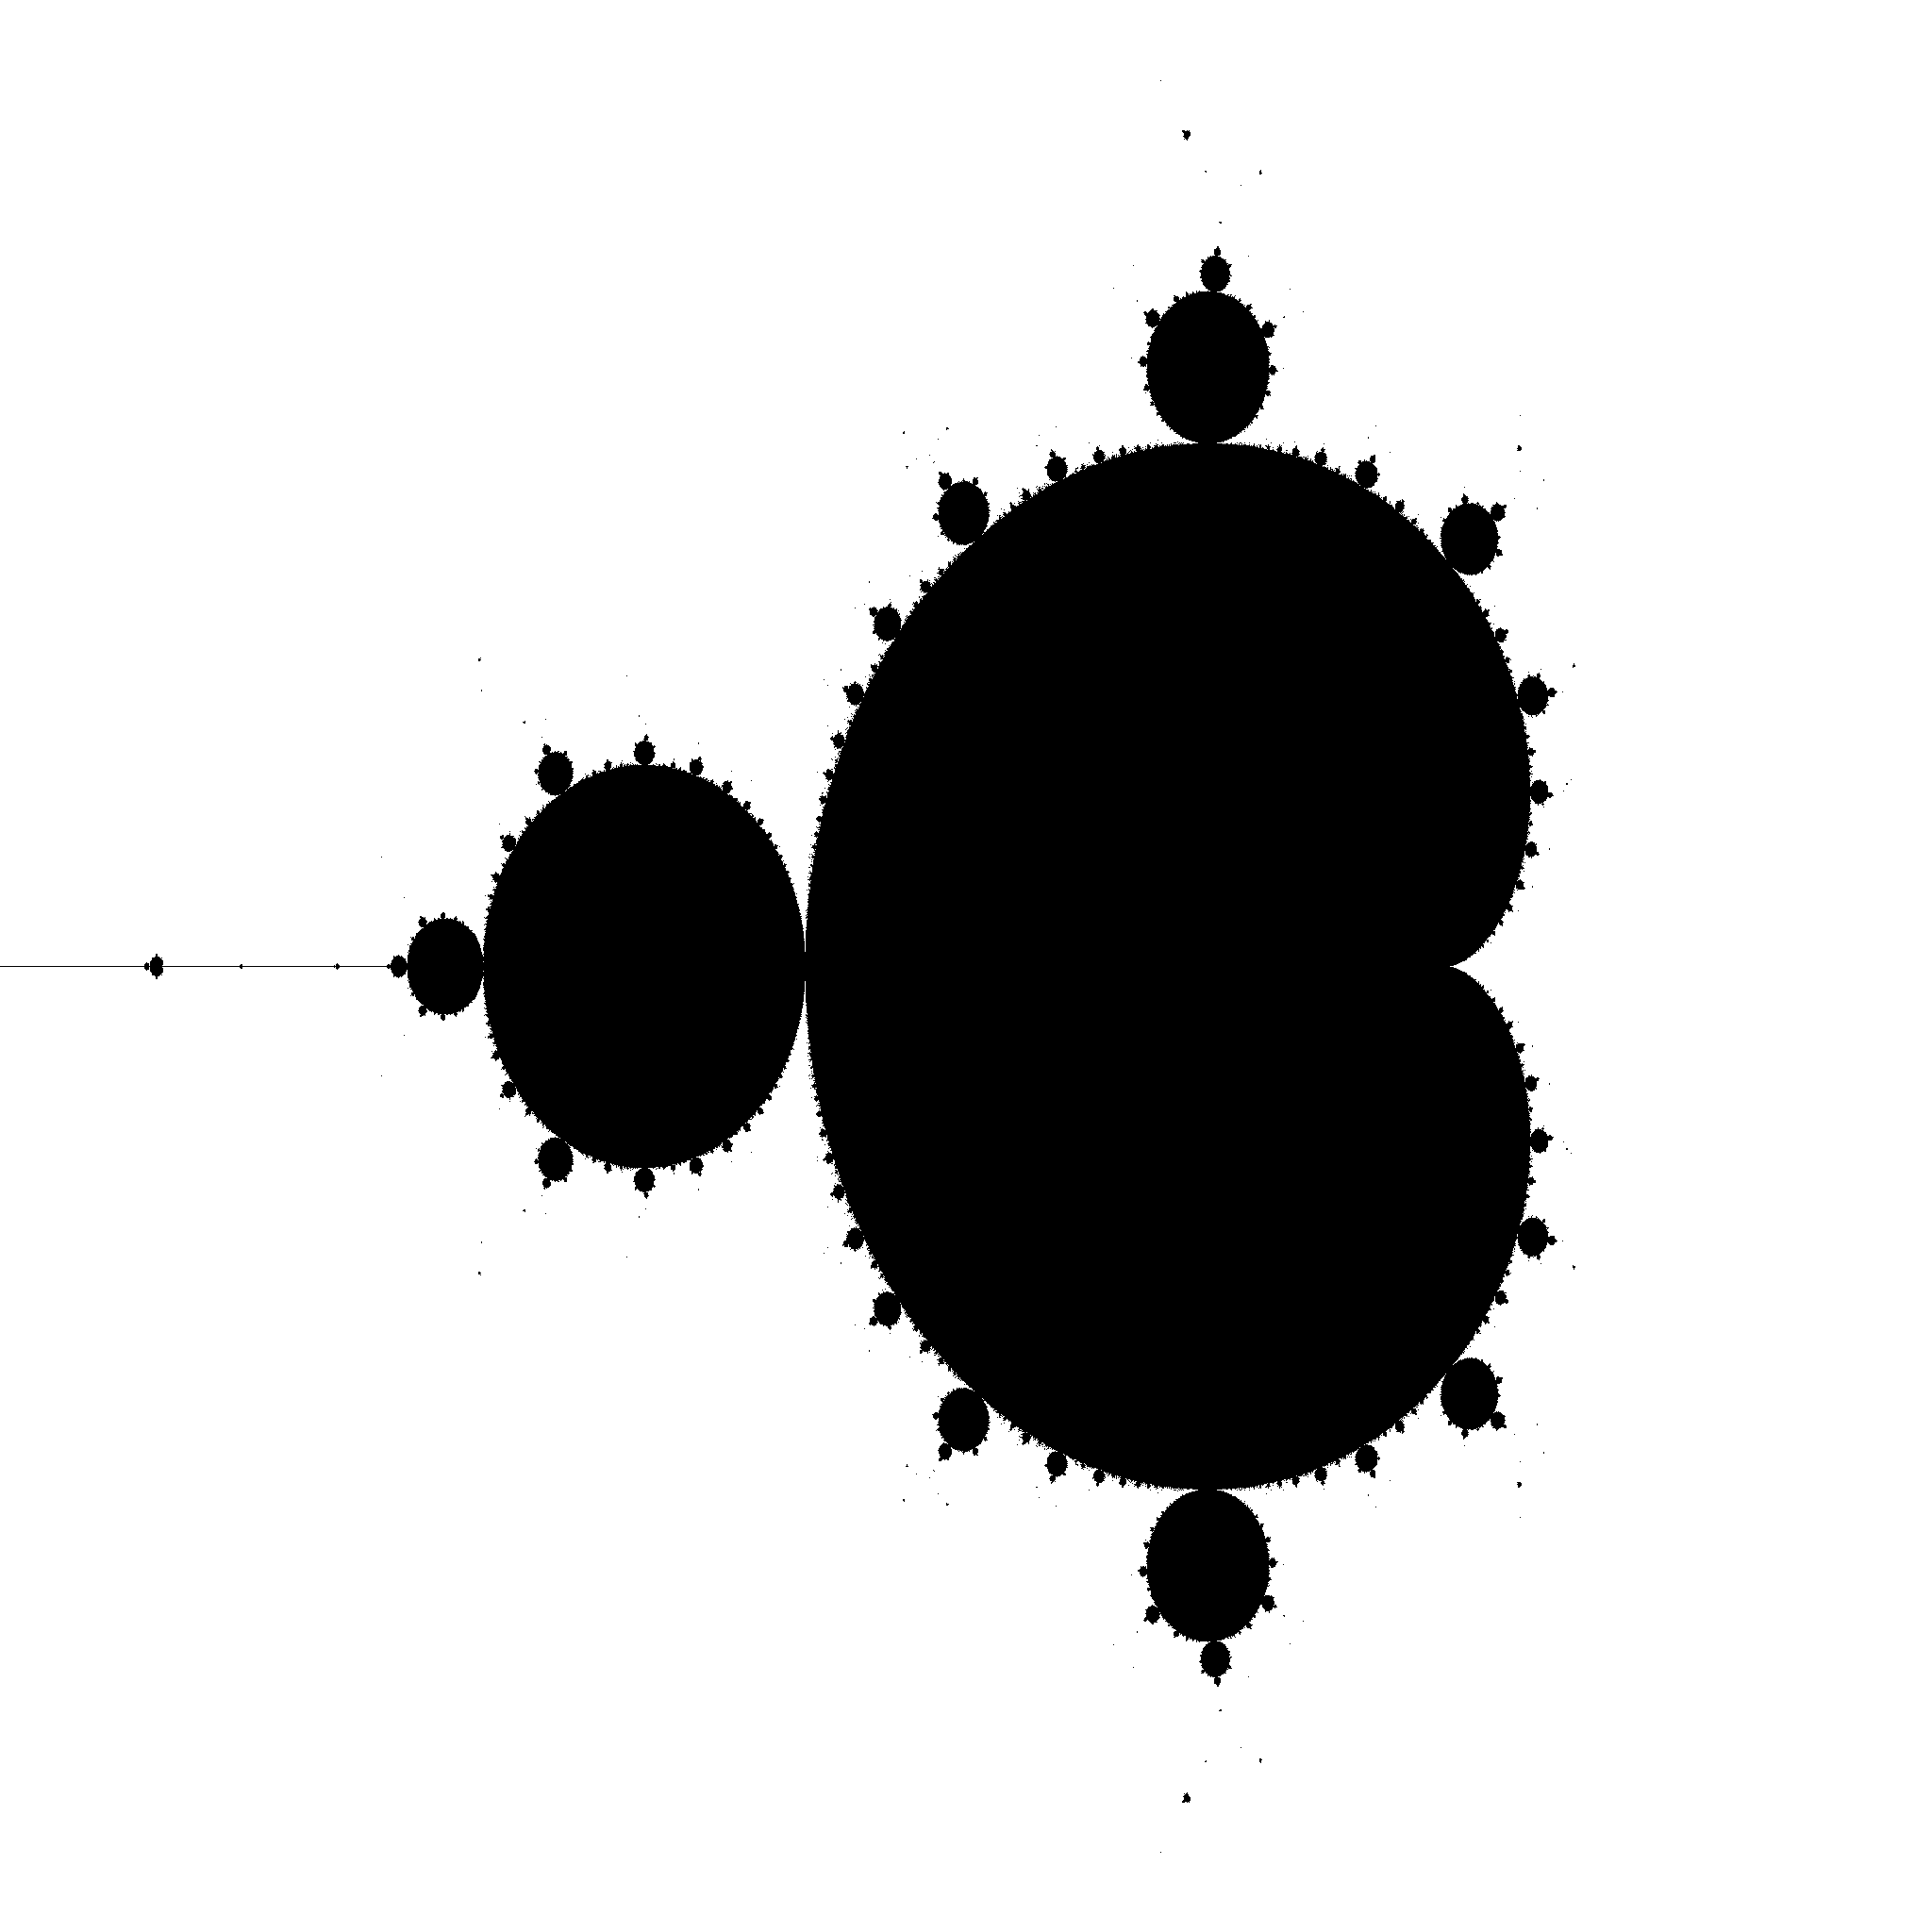

In [40]:
Image("out.png")

In [41]:
%%capture thr1
%%bash
OMP_NUM_THREADS=1 ./mandelbrot.exe

In [42]:
thr1.stdout

'spent 1902.723774 ms in parallel loop\n'

In [43]:
%%bash
OMP_NUM_THREADS=2 ./mandelbrot.exe

spent 956.289214 ms in parallel loop


In [44]:
%%bash
OMP_NUM_THREADS=4 ./mandelbrot.exe

spent 477.230795 ms in parallel loop


In [45]:
%%capture thr8
%%bash
OMP_NUM_THREADS=8 ./mandelbrot.exe

In [46]:
thr8.stdout

'spent 289.876555 ms in parallel loop\n'

**Final Speedup**

In [47]:
t1 = float(thr1.stdout.split()[1])
t8 = float(thr8.stdout.split()[1])
print("Final speedup ",t1/t8)

Final speedup  6.563910537711475


### OpenMP tasks

What will be printed by the following snippet?

    int main(int argc, char *argv[])
    {
        #pragma omp parallel
        {
            printf("A ");
            printf("race ");
            printf("car ");
        } 
        printf("\n");
        return 0;
    }

output depends on number of threads and execution sequence. The word order will be mixed. 

    int main(int argc, char *argv[])
    {
        #pragma omp parallel
        {
            #pragma omp single
            {
                printf("A ");
                printf("race ");
                printf("car ");
            } 
        printf("\n");
        return 0;
    }

this solves the problem but all threads but one are wasted. Using the **task** construct:

In [48]:
%%writefile sanrossore.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
//g. mancini july 18
int main()
{
    #pragma omp parallel
    {
        #pragma omp single
        {
            printf("A ");
            #pragma omp task
            printf("race ");
            #pragma omp task
            printf("horse ");
        } //single thread
    } //parallel region
    printf("\n");
    return 0;
}

Writing sanrossore.c


In [49]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -fopenmp -o race.exe sanrossore.c
OMP_NUM_THREADS=1 ./race.exe

A race horse 


In [50]:
%%bash
gcc -Wall -O2 -fopenmp -o race.exe sanrossore.c
OMP_NUM_THREADS=2 ./race.exe

A race horse 


Tasks are independent units of work. Threads are assigned to perform the work of each task.  

Tasks are composed of:  
- code to execute   
- data environment (it own its data)  
- internal control variables

Task barrier (`taskwait`): encountering thread suspends until all child tasks it has generated are completed.

Tasks can be executed in arbitrary order and generated until there is some work to do:

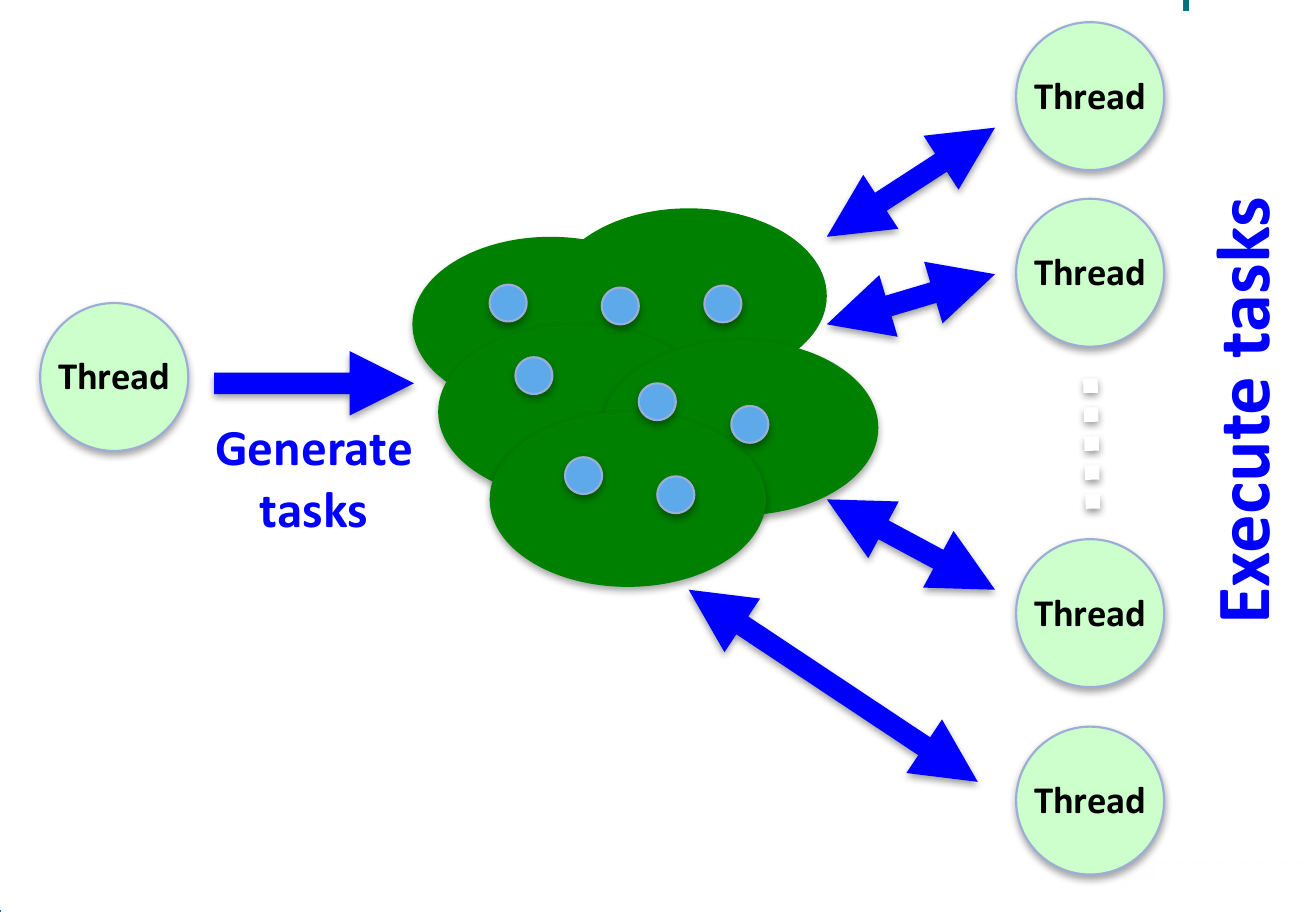

In [51]:
Image("pictures/tasks.png")

`taskwait` sets up some final work to do:

In [52]:
%%writefile sanrossore.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>

int main()
{
    #pragma omp parallel
    {
        #pragma omp single
        {
            printf("A ");
            #pragma omp task
            printf("race ");
            #pragma omp task
            printf("car ");
            #pragma omp taskwait
            printf(" or a horse one?");
        } //single thread
    } //parallel region
    printf("\n");
    return 0;
}

Overwriting sanrossore.c


In [53]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -fopenmp -o race.exe sanrossore.c
OMP_NUM_THREADS=2 ./race.exe

A race car  or a horse one?


### (Parallel) Design Patterns

**Design Patterns** - Qualitative description of a frequently occurring problem in some domain and its solution
- (object oriented programming, network apps...)

Description usually involves problem definition, driving forces, solution, benefits, difficulties, related
patterns.

**Pattern Language** - a collection of design patterns, guiding the users through the decision process in building a system.

- Parallel is hard and seldom exploits full hardware capabilities.
- A “cookbook” illustrating common problems and solutions would be handy (loop centric, divide and conquer ...)
- Provide a common vocabulary (factory pattern).
- Improve software reusability.

Flowchart:

- FindingConcurrency
    - data vs. control
- AlgorithmStructure
    - pipeline, replicate...
- SupportingStructure
    - SPMD, fork/join...
- Implementation
    - barriers, locks...

Common patterns:

- Embarassingly Parallel (Mandelbrot set)
- Replicable (Integral)
- Repository
- Divide and Conquer (Fibonacci with recursion)
- Pipeline
- Recursive Data
- Geometric
- IrregularMesh
- Inseparable

**The Divide and Conquer design pattern**

Divide and conquer is an important design pattern with two distinct phases

- Divide phase:  
    - Breaks down problem into two or more sub-problems of the same (or related) type.  
    - Continue division until these sub-problems become simple enough to be solved directly.  
- Conquer phase:  
    - Executes the computations on each of the “indivisible” sub-problems.  
    - May also combine solutions of sub-problems until the solution of the original problem is reached.  

Implementation is typically done with recursive algorithms. Why?

- Because the nature of recursion forms smaller sub-problems that are very much like the larger problem being solved.  
- The return from recursive calls can be used to combine partial solutions into an overall solution.  

How to implement it?  
- Define a split operation
- Continue to split the problem until subproblems are small enough to solve directly (you fix a threshold).  
- Recombine solutions to subproblems to solve original global problem. 

the Fibonacci sequence with tasks is an example of the *Divide and Conquer* design pattern: we spit until a known value is returned then merge again.

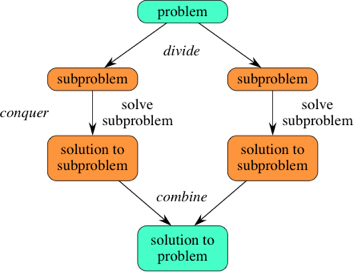

In [54]:
Image("pictures/dac.jpg")

**Fibonacci sequence with tasks**

    int fib ( int n )                  // n is private between tasks when called recursively
    {
        int x,y;
        if ( n < 2 ) return n;
        #pragma omp task shared (x)
            x = fib(n-1);
         #pragma omp task shared(y)
            y = fib(n-2);
         #pragma omp taskwait      //  explicit task barrier
            return x+y;            //  if x and y weren't shared they would stay with the inizialitation value
    }

#### The QuickSort algorithm

[QuickSort](#https://it.wikipedia.org/wiki/Quicksort) is a Divide and Conquer algorithm.  
It picks an element as **pivot** and *partitions* an input array around it, *forming two
new subarrays*. DaC is applied by calling iteratively QuickSort on the subarrays up to arrays
of lenght=2.  

The critical part is the **partition** procedure which moves the elements wrt to the pivot. Given an array `A` and a pivot `p`, **`partition`**, elements greater than the **pivot** go to the right and elements smaller (or equal) go to the left.

Different implementations of QuickSort pick the pivot in different ways; e. g.:

1. Pick first element.  
2. Pick last element.  
3. Pick a random element.  
4. Pick median (my choice but not for any insight).  


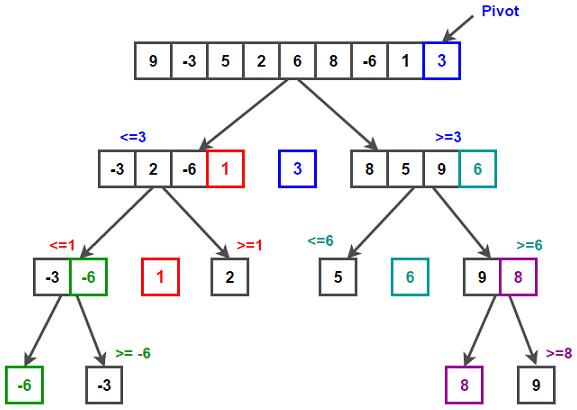

In [55]:
Image("pictures/Quicksort.png")

In [56]:
%%writefile quicksort.c
#include <stdlib.h>
#include <stdio.h>
//https://rosettacode.org/wiki/Sorting_algorithms/Quicksort#C

void quicksort(int *A, int len) 
{
    if (len < 2) return;
    int i, j, temp;
    //median element
    int pivot = A[len / 2];
    for (i = 0, j = len - 1; ; i++, j--)
    {
        //update position of last element to be moved on the right
        while (A[i] < pivot) i++;
        //update position of last element to be moved on the left
        while (A[j] > pivot) j--;
        if (i >= j) break;

        temp = A[i];
        A[i]     = A[j];
        A[j]     = temp;
    }

    //left branch
    quicksort(A, i);
    //right branch
    quicksort(A + i, len - i);
}

void printA(int *A, int L)
{
    for (int i = 0; i < L; i++) 
        printf("%d ", A[i]); 
    printf("\n");    
}

int main (int argc, char *argv[]) 
{
    int A[] = {10, 7, 8, 9, 1, 5, 7, 4}; 
    int length = sizeof(A)/sizeof(A[0]); 
    printf("Sorted array:\n"); 
    printA(A, length);
    printf("Unsorted array:\n"); 
    quicksort(A, length);
    printA(A, length);
    return 0;
}

Writing quicksort.c


In [57]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -msse4.2 -o QS.exe quicksort.c
./QS.exe

Sorted array:
10 7 8 9 1 5 7 4 
Unsorted array:
1 4 5 7 7 8 9 10 


### Exercise 2.1

Write an OpenMP version of QuickSort using tasks.

once you created a working version, try to use bigger arrays; fill it with random integers using the [GNU Scientific Library](#https://www.gnu.org/software/gsl/) random number generators; see [here](#https://www.gnu.org/software/gsl/doc/html/rng.html):

        gsl_rng *R = gsl_rng_alloc (gsl_rng_taus);
        gsl_rng_set(R, 211085);
        printf("Generating %d random integers in[%ld,%ld]\n",length,gsl_rng_min(R),gsl_rng_max(R));
        for( int i = 0; i < length; i++)
            Arr[i] =  gsl_rng_uniform_int(R, length);
        gsl_rng_free(R)
        
compile adding linker and preprocessor flags, e. g.:

    gcc ... -lm -lgsl -lgslcblas -I/usr/include/gsl/

add timing and some super simple check.

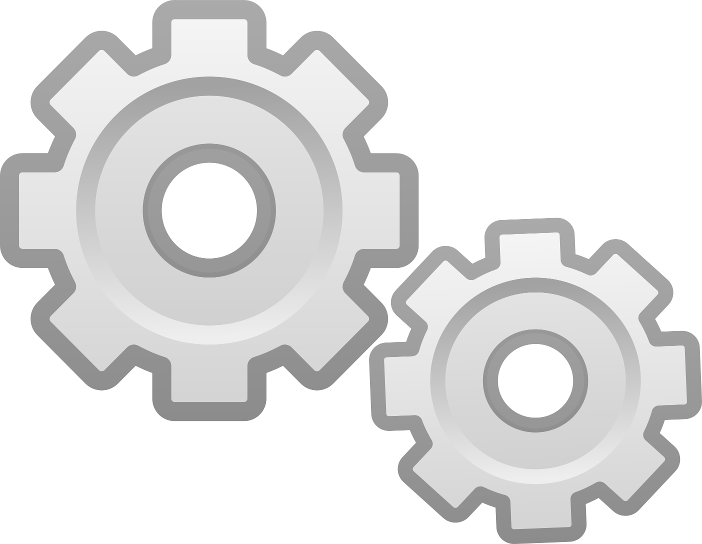

In [58]:
Image("pictures/gears.png")

### Solution 3.1

In [59]:
%%writefile quicksort_omp.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>
#include <gsl_rng.h>
//https://rosettacode.org/wiki/Sorting_algorithms/Quicksort#C

void quicksort(int *A, int len) 
{
    if (len < 2) return;
    int i, j, temp;
    //median element
    int pivot = A[len / 2];
    for (i = 0, j = len - 1; ; i++, j--)
    {
        //update position of last element to be moved on the right
        while (A[i] < pivot) i++;
        //update position of last element to be moved on the left
        while (A[j] > pivot) j--;
        if (i >= j) break;

        temp = A[i];
        A[i]     = A[j];
        A[j]     = temp;
    }

    //left branch
    #pragma omp task
    quicksort(A, i);
    //right branch
    #pragma omp task
    quicksort(A + i, len - i);
}

void printA(int *A, int L)
{
    for (int i = 0; i < L; i++) 
        printf("%d ", A[i]); 
    printf("\n");    
}

int main (int argc, char *argv[]) 
{
    int length = atoi(argv[1]);
    int *A = malloc(length * sizeof(int));
    gsl_rng *R = gsl_rng_alloc (gsl_rng_taus);
    gsl_rng_set(R, 211085);
    printf("Generating %d random integers in[%ld,%d]\n",length,gsl_rng_min(R),length);
    for( int i = 0; i < length; i++)
        A[i] =  gsl_rng_uniform_int(R, length);
    gsl_rng_free(R);

#ifdef VRB
        printf("Unsorted array:\n"); 
        printA(A, length);
#endif
 
    double t0 = omp_get_wtime();
    int nt;
    #pragma omp parallel
    {
        nt = omp_get_num_threads();
        {
            #pragma omp single
            quicksort(A, length); 
        }
    }
    
    printf("Sorted in %f with %d threads\n",omp_get_wtime()-t0,nt);
#ifdef VRB        
    printf("Sorted array:\n"); 
    printA(A, length);
#endif        
    return 0;
}

Writing quicksort_omp.c


In [60]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -msse4.2 -o QS.exe quicksort_omp.c \
-fopenmp -lm -lgsl -lgslcblas -I/usr/include/gsl/ -DVRB
OMP_NUM_THREADS=1 ./QS.exe 20

Generating 20 random integers in[0,20]
Unsorted array:
5 17 1 5 5 13 4 10 15 13 15 8 19 2 19 5 6 19 3 13 
Sorted in 0.000022 with 1 threads
Sorted array:
1 2 3 4 5 5 5 5 6 8 10 13 13 13 15 15 17 19 19 19 


In [61]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
OMP_NUM_THREADS=4 ./QS.exe 20

Generating 20 random integers in[0,20]
Unsorted array:
5 17 1 5 5 13 4 10 15 13 15 8 19 2 19 5 6 19 3 13 
Sorted in 0.000278 with 4 threads
Sorted array:
1 2 3 4 5 5 5 5 6 8 10 13 13 13 15 15 17 19 19 19 


In [62]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -msse4.2 -o QS.exe quicksort_omp.c \
-fopenmp -lm -lgsl -lgslcblas -I/usr/include/gsl/

In [63]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
OMP_NUM_THREADS=1 ./QS.exe 20000000

Generating 20000000 random integers in[0,20000000]
Sorted in 2.867167 with 1 threads


In [64]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
OMP_NUM_THREADS=2 ./QS.exe 20000000

Generating 20000000 random integers in[0,20000000]
Sorted in 1.557683 with 2 threads


In [65]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
OMP_NUM_THREADS=4 ./QS.exe 20000000

Generating 20000000 random integers in[0,20000000]
Sorted in 0.855291 with 4 threads


In [66]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
OMP_NUM_THREADS=8 ./QS.exe 20000000

Generating 20000000 random integers in[0,20000000]
Sorted in 0.728141 with 8 threads


<a id="three"></a>

# 3 - MPI

**MPI** (*Message Passing Interface*) is standard specification for message passing.  

- Implemented in several libraries, open source and proprietary.
    - [OpenMPI](#https://www.open-mpi.org/) and [MPICH](#https://www.mpich.org/) commonly used (and available in distro repositories ...)
- Designed for distributed computing (but it can be used for shared multiprocessing).  
- Portable.  
- C, C++ and Fortran bindings available.  
- Currently, version 3 of the standard available.  

**MPI features**

- The Program consists of a collection of processes (often counted by their *rank*).
- Number of processes almost always fixed at program startup time.  
- Each node has a local address space.  
- Logically shared data must be partioned.  
- Processes communicate by explicit **send/receive** pairs.

When an MPI program is run, multiple processes are executed and work of separate blocks of data.  
The collection of processes involved in a computationis called **a process group**.

Data is shared either with *one-to-one*:  

- `MPI_Send()`, 
- `MPI_Recv()`  

or *collective communications*:

- `MPI_Barrier()`
- `MPI_Gather()`
- `MPI_Scatter()`


Actually, there are *a lot* of functions:

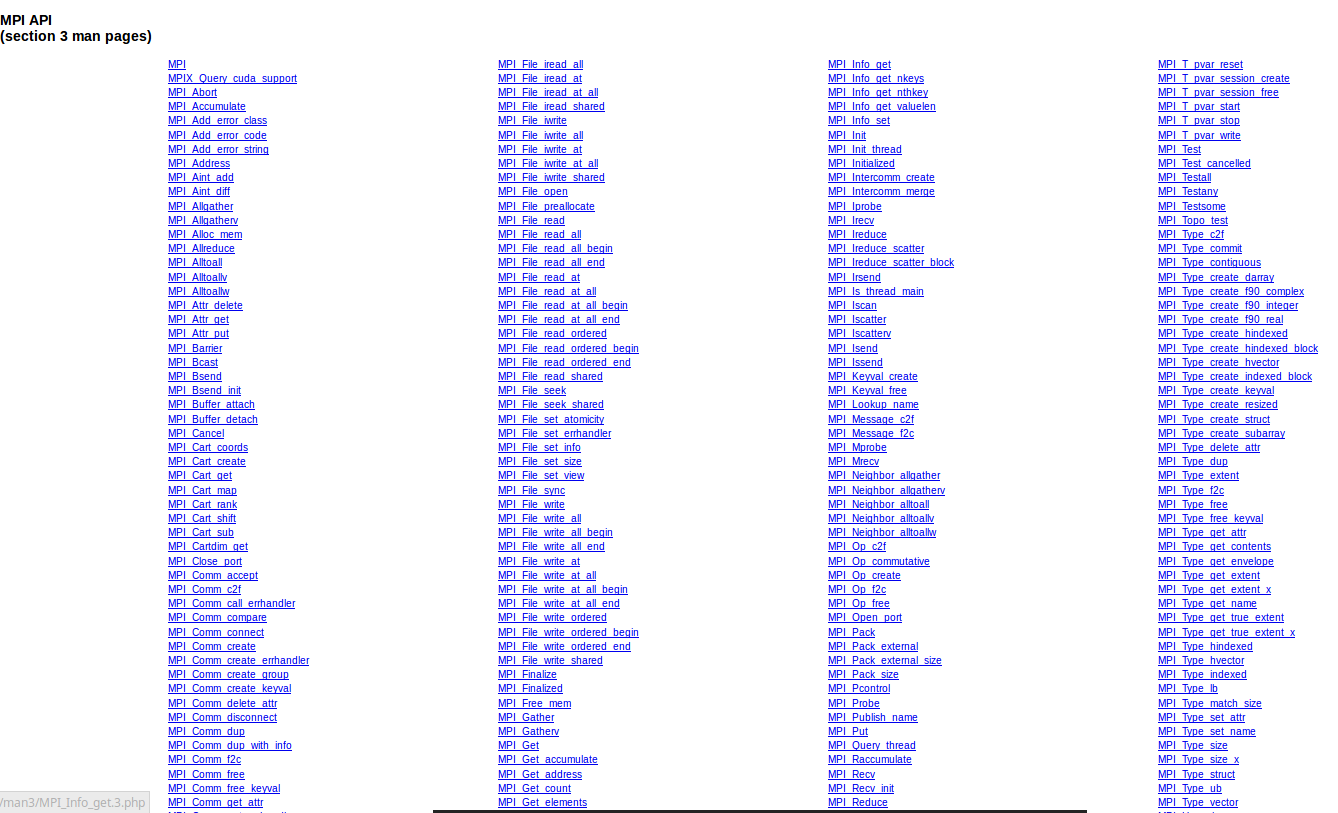

In [67]:
Image("pictures/mpi_funcs.png")

#### Example: Jacobi Solver

In [68]:
%%writefile jacobi.c
#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <mpi.h>
#include <string.h>
#include <omp.h>
//g. mancini july 18
double check_jacobi(int dim, double **A, double *b, double *xnew)
{
    double sum = 0.;    
    for(int i = 0; i < dim; i++)    
    {
        double sum_i = b[i];        
        for(int j = 0; j < dim; j++)    
            sum_i -= A[i][j] * xnew[j];        
        sum += pow(sum_i,2);
    }    
    return sqrt(sum/(double ) dim);
}

void gen_jac_input(int DIM, int high, double **A, double *b, double *xo)
{
    for (int i=0; i < DIM;i++)
    {
        b[i]  = (double ) (rand() % high);
        xo[i] = (double ) (rand() % high);
        double sum = 0.;

        for (int j=0; j< DIM; j++)
        {
            A[i][j] = (double ) (rand() % high);
            sum += A[i][j];
        }
        A[i][i] = 1.5 * (sum - A[i][i]);
    }
}

double do_iter(int rank, int first, int last, int dim, \
               double **A, double *b, double *xold, double *xnew)
{
        double conv = 0.;
        for(int i = first; i < last; i++)
        {
            double tmp = 0.;
            int row = i + rank*last;            
            #pragma omp simd reduction(+:tmp)
            for(int j = 0; j < dim; j++)
                tmp += xold[j] * A[row][j];
            xnew[i] = (b[row] - tmp + xold[row] * A[row][row])/A[row][row];
            conv += pow(xnew[i]-xold[row],2);
        }    
        return conv;
}

double jacobi(int dim, double **A, double *b, double *xold,\
    double *xnew, double tol, int kmax, int *niter)
{

    int rank, size;
#ifdef MPI_VERSION    
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
#else
    rank = 0;
    size = 1;  
#endif    
    
    double gconv = 1. + tol;
    int chunk = dim / size;
    int k = 0;
    
    while(k < kmax && gconv > tol)
    {        
        double conv = do_iter(rank, 0, chunk, dim, A, b, xold, xnew);
#ifdef MPI_VERSION                           
        if(rank == 0 && dim % size > 0)
        {
            conv += do_iter(0, size*chunk, dim, dim, A, b, xold, xnew);
            for(int i = size*chunk; i < dim; i++)
                xold[i] = xnew[i];
        }
        MPI_Allgather(xnew, chunk, MPI_DOUBLE, xold, chunk, MPI_DOUBLE,
            MPI_COMM_WORLD);

        if(dim % size > 0)
            MPI_Bcast(&xold[size*chunk], dim % size, MPI_DOUBLE, 0, MPI_COMM_WORLD);      
        MPI_Allreduce(&conv, &gconv, 1, MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD);
#else
        gconv = conv;
#endif        
        k++;
    }    
    memcpy(xnew,xold,sizeof(double) * dim);
    *niter = k;
    return gconv;
}

int main(int argc, char **argv)
{
    double tol = 1e-8;
    const int kmax = 100;
    const int DIM  = atoi(argv[1]);
    const int high = atoi(argv[2]);
    int niter;
    
    double t0 = 0., t1 = 0.;
    srand(23);
    
    //allocate
    double  **A = malloc(DIM * sizeof(double*));
    A[0] =  malloc(DIM * DIM * sizeof(double));
    for(int i = 1; i < DIM; i++)
        A[i] = A[0] + i*DIM;
    double  *b = malloc(DIM * sizeof(double));
    double *xo = malloc(DIM * sizeof(double));
    double *xn = calloc(DIM, sizeof(double));

    //generate A and b and make A diagonally dominant
    gen_jac_input(DIM, high, A, b, xo);
    
    int rank = 0;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    
    //call jacobi 
    t0 = MPI_Wtime();

    double conv = jacobi(DIM, A, b, xo, xn, tol, kmax, &niter);
      
    MPI_Finalize();
    t1 = MPI_Wtime();
    
    if(rank == 0)
    {
        if(niter < kmax)
            printf("converged at %g after %d iterations in %g s\n",conv,niter,t1-t0);
        else 
            printf("NOT converged (conv=%g) after %d iterations\n",conv,niter);
        
        //check results
        double error = check_jacobi(DIM, A, b, xn);
        printf("error=%f\n",error);
    }
   
}

Writing jacobi.c


In [69]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
mpicc -O2 -Wall -march=native -mtune=native -msse4.2 -lm -fopenmp -lmpi -o jacobi.exe jacobi.c
mpirun -n 1 jacobi.exe 4000 100

converged at 8.85065e-09 after 45 iterations in 0.559049 s
error=0.294429


In [70]:
%%bash
mpirun -n 2 jacobi.exe 4000 100

converged at 8.85065e-09 after 45 iterations in 0.370895 s
error=0.294429


In [71]:
%%bash
mpirun -n 4 jacobi.exe 4000 100

converged at 8.85065e-09 after 45 iterations in 0.32402 s
error=0.294429


### Non blocking communications

One can improve performance on many systems by *overlapping communication and computation*. 
A *nonblocking send* starts initiates the send operation, *but does not complete it*, returning *before the message copy is completed*.  
A *nonblocking receive* initiates the receive operation but returns storing the complete message.

Separates communication into three steps:
1. Initiate non-blocking communication  
    - returns immediately
    - routine name starting with MPI_I  
2. Do some work (
    - Local to the processes)
    - “latency hiding”  
3. Wait for non-blocking communication to complete  

    int MPI_Isend(void *buffer, int count, MPI_Datatype datatype, int dest, 
        int tag, MPI_Communicator comm, MPI_Request *request);
        
    int MPI_Irecv(void *buffer, int count, MPI_Datatype datatype, int source, int tag,
        MPI_Communicator comm, MPI_Request *request);

`MPI_Request` takes the role of `MPI_Status` in the blocking Recv but now is needed also by the send call.

Completition of the request is made with `MPI_Test`: 
    
    int MPI_Test(MPI_Request *request, int *flag, MPI_Status *status);

**ISend/Test** is then equivalent to **Send**.

testing can be delayed with **MPI_Wait()**:
    
    int MPI_Wait(MPI_Request *request, MPI_Status *status);

**Example: non blocking ring**

In [72]:
%%writefile ring_nb.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <mpi.h>
//g. mancini july 18
int main(int argc, char **argv)
{
    int rank, size, check, to, from;

    const char hdr[11] = ": sent to ";
    const char ftr[20] = " and received from ";
    char msg[33], rmsg[33] = " xxx" ;
    
    MPI_Request ReqS, ReqR;
    MPI_Status  Stat;       
    MPI_Init(&argc,&argv);
    
    MPI_Comm_rank(MPI_COMM_WORLD,&rank);
    MPI_Comm_size(MPI_COMM_WORLD,&size);

    check = rank % size;   
    if (check == 0)
    {
        to   = 1;
        from = size -1;
    } 
    else if (check == size-1)
    {
        to   = 0;
        from = rank -1; 
    }
    else
    {
        to   = check + 1;
        from = check - 1; 
    }

    snprintf(msg,sizeof(msg),"%d%s%d%s%d",rank,hdr,to,ftr,from);
    if (size > 1)
    {
        MPI_Isend(&msg[0], 35, MPI_BYTE, to, check, MPI_COMM_WORLD, &ReqS);
        MPI_Irecv(rmsg,35, MPI_BYTE, from, from, MPI_COMM_WORLD, &ReqR);                
        MPI_Wait(&ReqS, &Stat);
        MPI_Wait(&ReqR, &Stat);
        printf("%s \n",rmsg);
    }
    MPI_Finalize();
}

Writing ring_nb.c


In [73]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
mpicc -O2 -Wall -o ring.exe ring_nb.c  -march=native -mtune=native -lm -lmpi
mpirun -n 8 ring.exe 

7: sent to 0 and received from 6 
0: sent to 1 and received from 7 
3: sent to 4 and received from 2 
4: sent to 5 and received from 3 
2: sent to 3 and received from 1 
5: sent to 6 and received from 4 
6: sent to 7 and received from 5 
1: sent to 2 and received from 0 


**Geometric decomposition pattern**  
Dependencies exist, but communicate in predictable (geometric) neighbour-to-neighbour paths.  
Use Neighbour to  Neighbour communications.  
Examples: Finite differences, CFD, Molecular Dynamics.

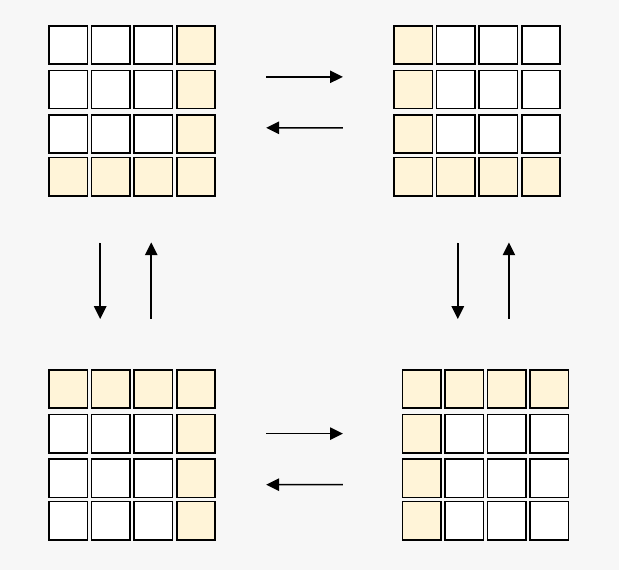

In [74]:
Image("pictures/geom_decomp.png")

#### Example: 1D heat equation

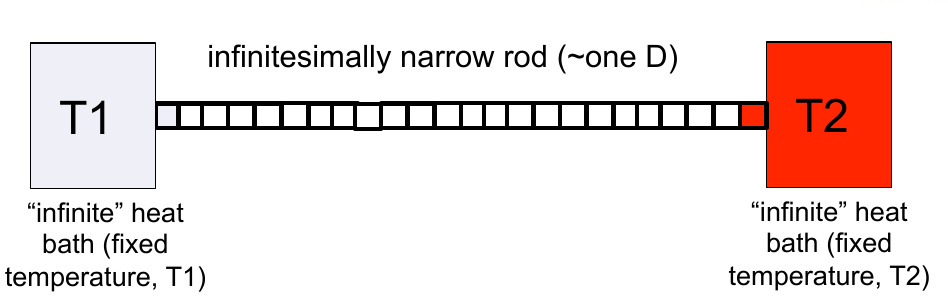

In [75]:
Image("pictures/rod.png")

Use first order and second order finite difference for time and space, respectively:

$$ \frac{\partial T}{\partial t}  = \frac{T^{n+1}-T^n}{\delta t} $$
$$ \frac{\partial^2 T}{\partial x^2}  = \frac{T_{j+1}-2.\cdot T_j+T_{j-1}}{\delta x} $$

then combine:

$$ T^{n+1}_j = T^{n}_j - r\cdot (T^{n}_{j+1} -2.\cdot T^n_j+T^n_{j-1} ) $$

where $$ r = \frac{\delta t}{{\delta x}^2} $$ must be less than 0.5 to converge.

How to parallelise this?   
Answer: *Geometric Decomposition pattern*:  Break it into chunks assigning one chunk to each process.  
Problem: end of chunk cells depend on each other across processes.  
Solution: use *ghost cells* to replicate data between processes. 

In [76]:
%%writefile heat.c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <mpi.h>
//gmancini may 18
int main()
{
    double H0 = 100., H1 = 100.; 

    int Ncell = 5e2; 
    int Nstep = 1e6; 
    
    double delta_t, delta_x, scalef;
    double *Temp, *Tnew, *swap;    
    
    int rank, size, chunk, first, last;
    
    MPI_Init(0,NULL);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    MPI_Status status;
    
    if (size > 1)
    {   
        if(Ncell % size != 0)
            Ncell = Ncell + Ncell % size;            
        chunk = Ncell / size + 2;
        first = 2;
        last  = chunk-2; 
        Temp = calloc(chunk, sizeof(double));
        Tnew = calloc(chunk, sizeof(double));

        if(rank == 0)
            Temp[1] = H0;
        if(rank == size-1)
            Temp[chunk-2] = H1;
    } 
    else
    {
        first = 1;
        last  = Ncell - 1;
        chunk = Ncell;
        
        Temp = calloc(Ncell, sizeof(double));
        Tnew = calloc(Ncell, sizeof(double));        
        Temp[0] = H0;
        Temp[Ncell-1] = H1;        
    }
    
    for(int i = first-1; i <= last+1; i++)
        Tnew[i] = Temp[i];
    
    delta_x = 1. / ((double ) Ncell);
    delta_t = 1. / ((double ) Nstep);
    scalef = delta_t / (delta_x * delta_x);    
    
    if(rank == 0) 
        printf("scalef, Ncell, chunk: %f %d %d \n",scalef,Ncell,chunk);
   
    for(int time = 0; time < Nstep; time++) 
    {   
       if (size > 1)
       {
           // has a left neighbour
            if(rank != 0) 
            {
                MPI_Send(&Temp[1], 1, MPI_DOUBLE, rank-1, rank, MPI_COMM_WORLD);
                MPI_Recv(&Temp[0], 1, MPI_DOUBLE, rank-1, rank-1, MPI_COMM_WORLD, &status);
            }
            // has a right neighbour
            if(rank != size - 1) 
            {
                MPI_Recv(&Temp[last+1], 1, MPI_DOUBLE, rank+1, rank+1, MPI_COMM_WORLD, &status);
                MPI_Send(&Temp[last], 1, MPI_DOUBLE, rank+1, rank, MPI_COMM_WORLD);
            }
       } //endif size > 1

        //apply stencil
        for(int cell = first; cell < last; cell++) 
            Tnew[cell] = Temp[cell] + scalef * (Temp[cell+1] - 2.*Temp[cell] + Temp[cell-1]);
        
        if(size > 1)
        {
            // 0 is a ghost cell
            if(rank != 0)
                Tnew[1] = Temp[1] + scalef * (Temp[2] - 2.*Temp[1] + Temp[0]);
                
            // chunk+2-1 is a ghost cell
            if(rank != size - 1)
                Tnew[last] = Temp[last] + scalef * (Temp[last+1] - 2.*Temp[last] + Temp[last-1]);
        }
        swap = Tnew;
        Tnew = Temp;
        Temp = swap;
    } //end for time
    
    if (size > 1)
    {
        swap = calloc(Ncell, sizeof(double)); 
        MPI_Allgather(&Tnew[1],last,MPI_DOUBLE,swap,last,MPI_DOUBLE,MPI_COMM_WORLD);
    }
    MPI_Finalize();

    if (rank == 0) 
    {
    char outname[30] = "temp_field_np_";
    char SZ[10];
    sprintf(SZ,"%d",size);
    strcat(outname, SZ);

    FILE *fp = fopen(outname, "w");
    for(int i = 0; i < Ncell; i++)
            fprintf(fp,"%d %f\n", i, swap[i]); 
    fclose(fp);
    }
    return 0;
}

Writing heat.c


In [77]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
mpicc --version
mpicc -Wall -O2 -march=native -mtune=native -lm -lmpi -o heat.exe heat.c

gcc (GCC) 7.3.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [78]:
%%bash
mpirun -n 2 ./heat.exe

scalef, Ncell, chunk: 0.250000 500 252 


In [79]:
%%bash
mpirun -n 4 ./heat.exe

scalef, Ncell, chunk: 0.250000 500 127 


In [80]:
%%bash
paste temp_field_np_2 temp_field_np_4 | awk 'NR>1{a+=($2-$4)*($2-$4)}END{print a/(NR-1)}'

0


### Exercise 3.0

Write a new version of `heat.c` using non blocking communications.

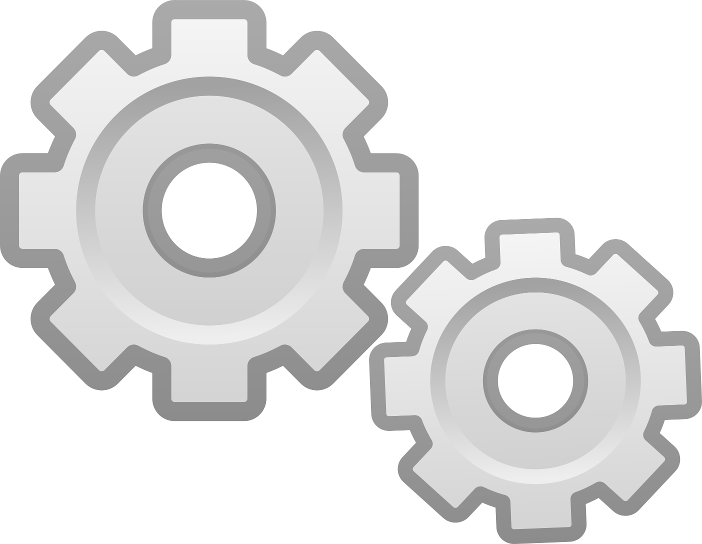

In [81]:
Image("pictures/gears.png")

### Solution 3.0

In [82]:
%%writefile heat_nb.c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <mpi.h>
//g mancini may 18
int main()
{
    double H0 = 100., H1 = 100.; 

    int Ncell = 5e2; 
    int Nstep = 1e6; 
    
    double delta_t, delta_x, scalef;
    double *Temp, *Tnew, *swap;    
    
    int rank, size, chunk, first, last;
    
    MPI_Init(0,NULL);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    MPI_Request Requests[4];
        
    if (size > 1)
    {   
        if(Ncell % size != 0)
            Ncell = Ncell + Ncell % size;            
        chunk = Ncell / size + 2;
        first = 2;
        last  = chunk-2; 
        Temp = calloc(chunk, sizeof(double));
        Tnew = calloc(chunk, sizeof(double));

        if(rank == 0)
            Temp[1] = H0;
        if(rank == size-1)
            Temp[chunk-2] = H1;
    } 
    else
    {
        first = 1;
        last  = Ncell - 1;
        chunk = Ncell;
        
        Temp = calloc(Ncell, sizeof(double));
        Tnew = calloc(Ncell, sizeof(double));        
        Temp[0] = H0;
        Temp[Ncell-1] = H1;        
    }
    
    for(int i = first-1; i <= last+1; i++)
        Tnew[i] = Temp[i];
    
    delta_x = 1. / ((double ) Ncell);
    delta_t = 1. / ((double ) Nstep);
    scalef = delta_t / (delta_x * delta_x);    
    
    if(rank == 0) 
        printf("scalef, Ncell, chunk: %f %d %d \n",scalef,Ncell,chunk);
   
    for(int time = 0; time < Nstep; time++) 
    {   
       //Send data
       if (size > 1)
       {
           //has a left neighbour
            if(rank != 0) 
                MPI_Irecv(&Temp[0], 1, MPI_DOUBLE, rank-1, rank-1, 
                          MPI_COMM_WORLD, &Requests[0]);
            //has a right neighbour
            if(rank != size - 1) 
                MPI_Irecv(&Temp[last+1], 1, MPI_DOUBLE, rank+1, rank+1, 
                          MPI_COMM_WORLD, &Requests[1]);
           //has a left neighbour
            if(rank != 0)            
                MPI_Isend(&Temp[1], 1, MPI_DOUBLE, rank-1, rank, 
                          MPI_COMM_WORLD, &Requests[2]);
           //has a right neighbour
            if(rank != size - 1)            
                MPI_Isend(&Temp[last], 1, MPI_DOUBLE, rank+1, rank, 
                          MPI_COMM_WORLD, &Requests[3]);            
       } //endif size > 1

        //apply stencil
        for(int cell = first; cell < last; cell++) 
            Tnew[cell] = Temp[cell] + scalef * (Temp[cell+1] - 2.*Temp[cell] + Temp[cell-1]);
        
        //receive
        if(size > 1)
        {
            if(rank != 0)
            {
                MPI_Wait(&(Requests[0]),MPI_STATUS_IGNORE);
                MPI_Wait(&(Requests[2]),MPI_STATUS_IGNORE);
                Tnew[1] = Temp[1] + scalef * (Temp[2] - 2.*Temp[1] + Temp[0]);
            }
            if(rank != size - 1)
            {
                MPI_Wait(&(Requests[1]),MPI_STATUS_IGNORE); 
                MPI_Wait(&(Requests[3]),MPI_STATUS_IGNORE);
                Tnew[last] = Temp[last] + scalef * (Temp[last+1] 
                - 2.*Temp[last] + Temp[last-1]);
            }
        }
        swap = Tnew;
        Tnew = Temp;
        Temp = swap;
    } //end for time
    
    if (size > 1)
    {
        swap = calloc(Ncell, sizeof(double)); 
        MPI_Allgather(&Tnew[1],last,MPI_DOUBLE,swap,last,MPI_DOUBLE,MPI_COMM_WORLD);
    }

    MPI_Finalize();
    if (rank == 0) 
    {
        char outname[30] = "temp_field_np_";
        char SZ[10];
        sprintf(SZ,"%d",size);
        strcat(outname, SZ);
        FILE *fp = fopen(outname, "w");
        for(int i = 0; i < Ncell; i++)
            fprintf(fp,"%d %f\n", i, swap[i]); 
        fclose(fp);
    }
    return 0;
}

Writing heat_nb.c


In [83]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
mpicc --version
mpicc -Wall -O2 -march=native -mtune=native -lm -lmpi -o heat_nb.exe heat_nb.c

gcc (GCC) 7.3.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [84]:
%%bash
mpirun -n 4 ./heat_nb.exe

scalef, Ncell, chunk: 0.250000 500 127 


In [85]:
%%bash
paste temp_field_np_2 temp_field_np_4 | awk 'NR>1{a+=($2-$4)}END{print a/(NR-1)}'

0


### Combining MPI and OpenMP

Combining MPI and OpenMP *in theory* can give benefits:

1. use non local resources for even bigger problems
2. use light weight thread and locality in sockets with OpenMP

... yes, I lied

In [86]:
%%writefile integral_mpi_omp.c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <mpi.h>
#include <omp.h>
//g. mancini july 18
int main(int argc, char **argv)
{
    long num_steps = 1e8;
    const double start  = 0.;
    const double end    = 1.;
    const double dx = (end-start) / ((double ) num_steps);
    double PI = 0.;
    int nt;
    
    int rank, size, provided;
    MPI_Init_thread(0,NULL,MPI_THREAD_FUNNELED,&provided);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    if(rank==0)
        printf("Provided mode %d\n",provided);

    double t0 = MPI_Wtime();
    if(num_steps % size != 0)
        num_steps += num_steps/size;
    int chunk = num_steps / size;
    int i0 = rank*chunk;
    int i1 = (rank+1)*chunk;
    
    double I  = 0.;
    #pragma omp parallel for simd reduction(+:I) 
    for(int i = i0; i < i1; i++)
    {
        nt = omp_get_num_threads();
        double mid_x = start + dx * ((double ) i + 0.5);
        double mid_y = 4.0/(1. + mid_x*mid_x) ;
        I += mid_y;
    }
    MPI_Reduce(&I, &PI, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);
    PI = PI * dx;
    double t1 = MPI_Wtime();
    MPI_Finalize();
    if(rank==0)
    {
        printf("Loop completed in %f using %d procs and %d threads\n",1000.*(t1-t0),size,nt);
        printf("Integral value %f\n",PI);
    }
}

Writing integral_mpi_omp.c


In [87]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
gcc -Wall -O2 -march=native -mtune=native -msse4.2 -fopenmp -fopenmp-simd -fopt-info-vec \
-o I.exe  integral_mpi_omp.c -lm -lmpi

integral_mpi_omp.c:35:38: note: loop vectorized


In [88]:
%%bash
source $HOME/Dropbox/Slackware/gcc_vars.sh
OMP_NUM_THREADS=4 mpirun -n 2 ./I.exe

Provided mode 1
Loop completed in 104.758742 using 2 procs and 4 threads
Integral value 3.141593


**Caveats**

1. Messages are sent to a **process** not to a particular thread.  

Not all MPIs are threadsafe. MPI 2.0 defines threading modes:  
- MPI_Thread_Single: no support for multiple threads.  
- MPI_Thread_Funneled: Multiple threads, only master calls MPI.    
- MPI_Thread_Serialized: Mult threads each calling MPI, but they do it one at a time.  
- MPI_Thread_Multiple: Multiple threads without any restrictions.  

Check out threading mode with:  
    `MPI_init_thread(desired_mode, delivered_mode, ierr)`

Environment variables are **not** propagated by mpirun.  
Youʼll need to broadcast OpenMP parameters and set them with the library routines.  

### Exercise 3.1

Add multithreading to `heat.c`. Increase problem size and run some benchmarks.

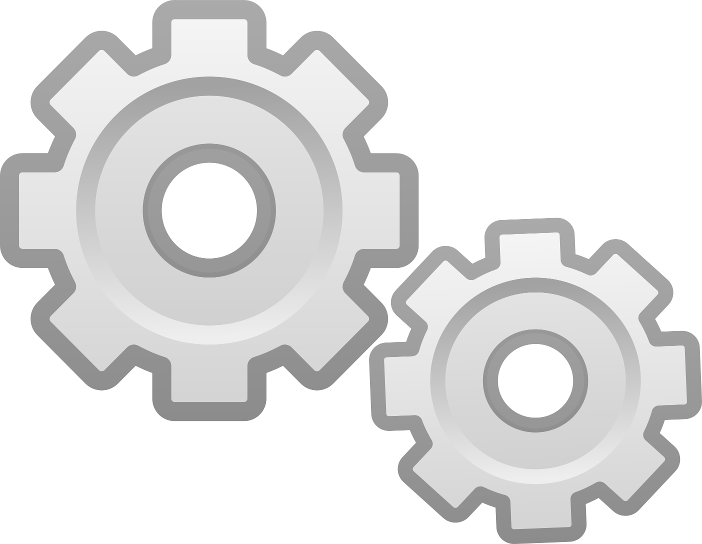

In [89]:
Image("pictures/gears.png")

### Solution 3.1

almost trivial

just add `#pragma omp parallel for simd` above the stencil.

From Tim Mattson: 

Literature is mixed on the hybrid model: sometimes its better, sometimes MPI alone is best.  
There is potential for benefit to the hybrid model because:

1. MPI algorithms often require replicated data making them less memory efficient.  
2. Fewer total MPI communicating agents means fewer messages and less overhead from message conflicts.  
3. Algorithms *with good cache efficiency* should benefit from shared caches of multi-threaded programs.  

The model maps perfectly with clusters of SMP nodes. But really, itʼs a case by case basis and to large extent depends on the particular application.  